<a href="https://colab.research.google.com/github/Maxmuleiv/Proyecto-Industrial/blob/master/AnalisisPobrezaMultidimensional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1- Importación Packages


In [0]:
%reset-f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import networkx as nx
from scipy.stats import pointbiserialr
from math import pi
!pip install squarify #pip install squarify #(algorithm for treemap)
import squarify
from matplotlib_venn import venn3
import matplotlib.patches as mpatches


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#2- Importación BD


In [0]:
url4="/content/drive/My Drive/CASEN45.csv" #url base datos 
casen = pd.read_csv(url4,";", encoding='iso-8859-1') #importación base datos para calculo tipo hogares y tipologias de las carencias

In [0]:
#url3="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/CASENtipologias.csv?raw=true" #url base datos 
#casen = pd.read_csv(url3,";", encoding='iso-8859-1') #importación base datos para calculo tipo hogares y tipologias de las carencias

#3- Categorizacion por tipo de familia


In [0]:
casen2=np.array(casen);#print(casen2)
hogares_unicos,hogares_index,hogares_inv,hogares_count=np.unique(casen2[:,0],return_index=True, return_inverse=True, return_counts=True)
n_hogares=len(hogares_unicos)
n_personas=len(casen2[:,0])
cols=np.array(casen[["pco1","numper","tot_nuc"]])

dd=np.zeros((n_hogares,1))
ddd=np.zeros((n_personas,1))
for i,h in enumerate(hogares_unicos):
  #print(h,i)
  miembros=np.where(casen2[:,0]==h)[0]#;print(miembros)
  #n_miembros=len(miembros)
  m_cols=cols[miembros]
  a=0
  if 2 in m_cols[:,0] or 3 in m_cols[:,0]:
    a=1;#print(h,"tiene pareja")
  b=m_cols[0,1]
  c=m_cols[0,2]
  #print(a,b,c)
  if b==1: #hogar unipersonal
    d=1
  elif b==c:
    d=6 #hogar censal   
  elif b>1 and a==0 and c==1:
    d=2 #hogar monoparental nuclear
  elif b>1 and a==1 and c==1:
    d=3 #hogar biparental nuclear
  elif b>1 and a==0 and c>1:
    d=4 #hogar monoparental extendido
  elif b>1 and a==1 and c>1:
    d=5 #hogar biparental extendido
  
  dd[i]=d
  ddd[miembros]=d
# dd es un arreglo por hogar único que indica que tipo de hogar es
# ddd es el tipo de hogar al que pertenecen los miembros
casen["d"]=ddd.astype(int)
#casen.head()
casen.rename(columns = {'Pobreza 5D':'PobMult'}, inplace = True) 
casen_general=casen.copy()
casen=casen[casen.pobreza_multi_5d == "Pobre"]


casen.head()

,folio,o,id_vivienda,hogar,zona,tot_hog,tot_per,tot_par,tot_nuc,pco1,nucleo,pco2,yautcor,ytotcor,yautcorh,ymonecorh,ytotcorh,yoprcor,yoprcorh,ytrabajocor,ytrabajocorh,ypchautcor,ypc,ypchtrabajo,pobreza,qaut,qautr,numper,iae,iai,hacinamiento,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,pobreza_multi_5d,d
1,110110020301,1,1101100203,1,Urbano,1,1,0,1,1.0,1,1,200000.0,211091.0,200000,211091,211091,200000.0,200000.0,200000.0,200000,200000,211091,200000.0,No pobres,III,III,1.0,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pobre,1
7,110110020601,1,1101100206,1,Urbano,1,2,0,1,1.0,1,1,130000.0,130000.0,463333,463333,463333,50000.0,50000.0,130000.0,130000,231667,231667,65000.0,No pobres,III,III,2.0,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,Pobre,2
8,110110020601,2,1101100206,1,Urbano,1,2,0,1,5.0,1,5,333333.0,333333.0,463333,463333,463333,NaN,NaN,NaN,130000,231667,231667,65000.0,No pobres,III,III,2.0,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,Pobre,2
19,110110030401,1,1101100304,1,Urbano,1,1,0,1,1.0,1,1,200000.0,200000.0,200000,200000,200000,200000.0,200000.0,200000.0,200000,200000,200000,200000.0,No pobres,III,III,1.0,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,Pobre,1
26,110110040201,1,1101100402,1,Urbano,1,1,0,1,1.0,1,1,442550.0,447482.0,442550,447482,447482,250000.0,250000.0,333333.0,333333,442550,447482,333333.0,No pobres,V,V,1.0,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,Pobre,1


#4- Definición funciones


In [0]:
# FUNCION PARA OBTENCION HEATMAPS POR TIPO DE CORRELACION (PEARSON, KENDALL Y SPEARMAN)
def creacion_heatmap(Nombre_metodo,Tabla_variables,Negativos,Comentario_grafico):
  

  if  Negativos==False:
    color_min=-0.01
  else:
    color_min=-0.5
    
  Tabla_correlaciones = Tabla_variables.corr(method=Nombre_metodo)
  plt.figure(figsize = (20,10)) #arreglar el tamaño del gráfico

  mask = np.zeros(Tabla_correlaciones.shape, dtype=bool) #eliminacion datos simetricos
  mask[np.triu_indices(len(mask))] = True

  mapa=sb.heatmap(Tabla_correlaciones.values.round(2), xticklabels=Tabla_correlaciones.columns, # heatmap pearson
            yticklabels=Tabla_correlaciones.columns,vmin =color_min, vmax = 0.5, center = 0, cmap = "RdBu",annot=True, mask=mask, linewidths=3)


#antes fije vmax en 0.12 por si lo quiero volver a poner
  b, t = mapa.get_ylim() # identificar limites de corte
  mapa.set_ylim(b + 0.5, t - 0.5) #redefinir limites de corte
  plt.savefig("Heatmap_"+Nombre_metodo+"_"+Comentario_grafico+".png",bbox_inches="tight")
  plt.savefig("Heatmap_"+Nombre_metodo+"_"+Comentario_grafico+".svg",bbox_inches="tight")
  Tabla_correlaciones.to_excel(excel_writer = Comentario_grafico+"correlaciones.xlsx")
  return
  plt.show()

# set carencias y set dimensiones
jjj=["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]
hhh=["Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social"]



#5- Cálculo correlaciones carencias




In [0]:
casen_hogares=casen[["folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
casen_hogares=casen_hogares.drop_duplicates()
casen_hogares = casen_hogares.drop(['folio'],axis=1)
pearson5d = casen_hogares.corr(method='pearson')
print(len(casen_hogares.index))
print(len(casen.index))

12392
44972


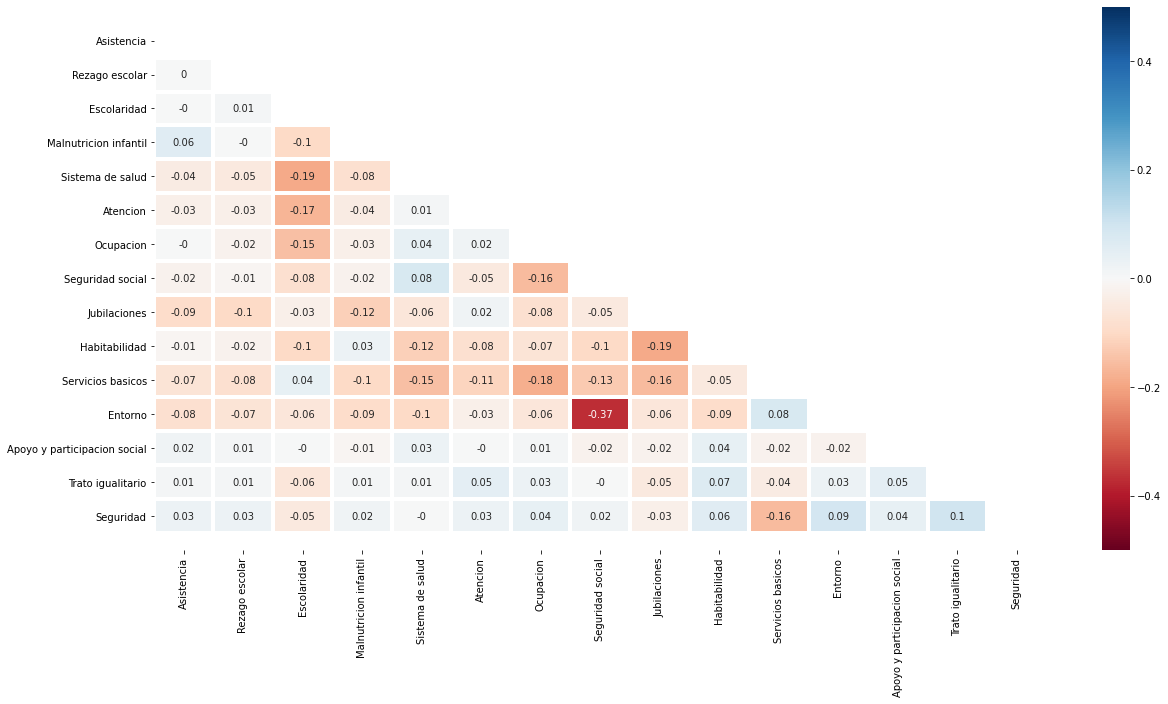

In [0]:
creacion_heatmap("pearson",casen_hogares,True,"carencias 1")


In [0]:
# importacion datos correlaciones excel

pearson5d.to_excel(excel_writer = "pearson5d.xlsx")


# Correlaciones por zona

frecuencia hogares rurales: 4743
frecuencia hogares urbanos: 7649
12392


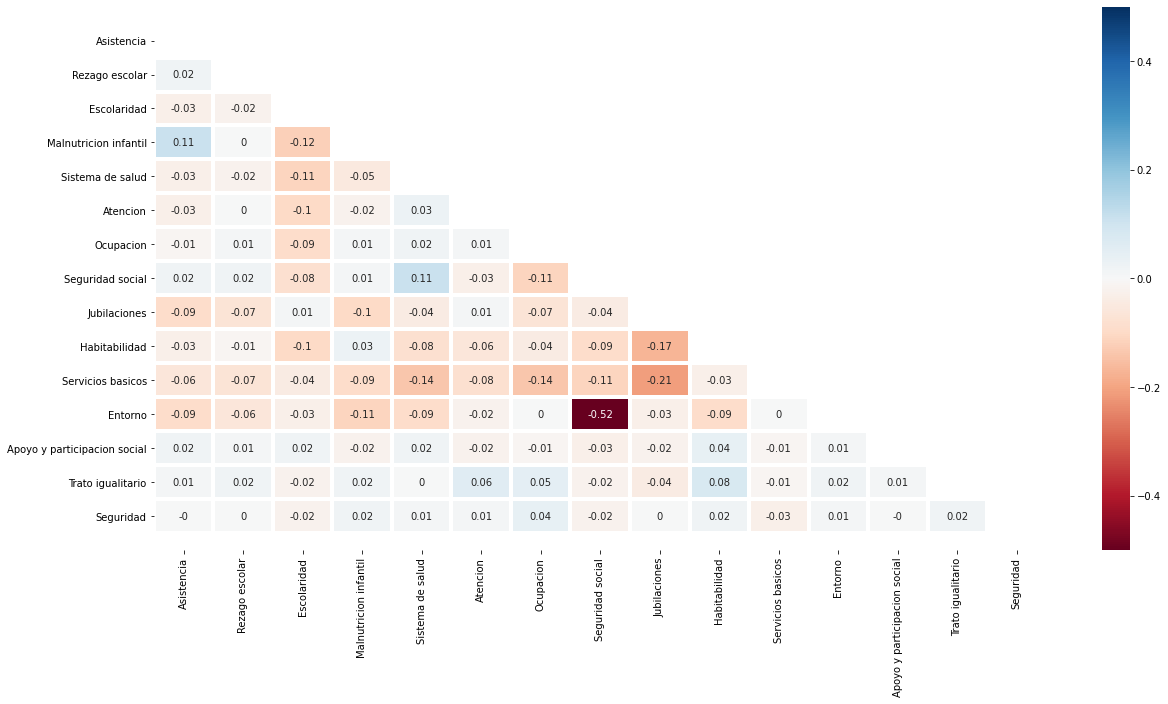

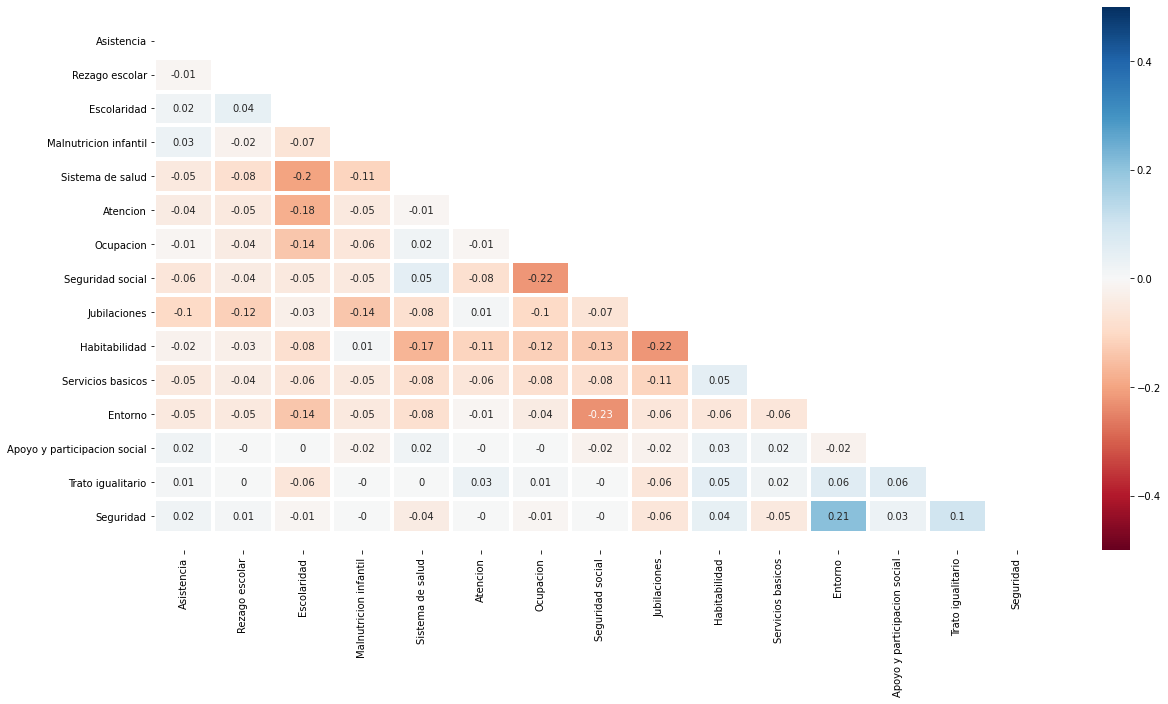

In [0]:
casen_zona=casen[["folio","zona","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
casen_zona=casen_zona.drop_duplicates()
casen_zona = casen_zona.drop(['folio'],axis=1)

casen_urbano=casen_zona[casen_zona.zona == "Urbano"]
casen_rural=casen_zona[casen_zona.zona == "Rural"]



pearson_urbano = casen_urbano.corr(method='pearson')
pearson_rural = casen_rural.corr(method='pearson')

num_urbano=len(casen_urbano.index)
num_rural=len(casen_rural.index)
print("frecuencia hogares rurales:", num_rural)
print("frecuencia hogares urbanos:",num_urbano)
print(num_urbano+num_rural)

creacion_heatmap("pearson",casen_rural,True,"rural")
creacion_heatmap("pearson",casen_urbano,True,"urbano")

pearson_urbano.to_excel(excel_writer = "corr_urbano.xlsx")
pearson_rural.to_excel(excel_writer = "corr_rural.xlsx")

# Correlaciones Numper

In [0]:
casen_numper=casen[["folio","zona","numper","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
casen_numper=casen_numper.drop_duplicates()
casen_numper = casen_numper.drop(['folio'],axis=1)

#calculo frecuencias por numper
print("frecuencia por numer")
casen_numper['numper'].value_counts()


frecuencia por numer


3.0     2681
2.0     2607
4.0     2305
5.0     1780
1.0     1246
6.0      911
7.0      401
8.0      240
9.0      108
10.0      84
11.0      16
12.0       8
14.0       2
15.0       1
13.0       1
16.0       1
Name: numper, dtype: int64

In [0]:
print("frecuencia porcentual numper")
casen_numper['numper'].value_counts(normalize=True)

frecuencia porcentual numper


3.0     0.216349
2.0     0.210378
4.0     0.186007
5.0     0.143641
1.0     0.100549
6.0     0.073515
7.0     0.032360
8.0     0.019367
9.0     0.008715
10.0    0.006779
11.0    0.001291
12.0    0.000646
14.0    0.000161
15.0    0.000081
13.0    0.000081
16.0    0.000081
Name: numper, dtype: float64

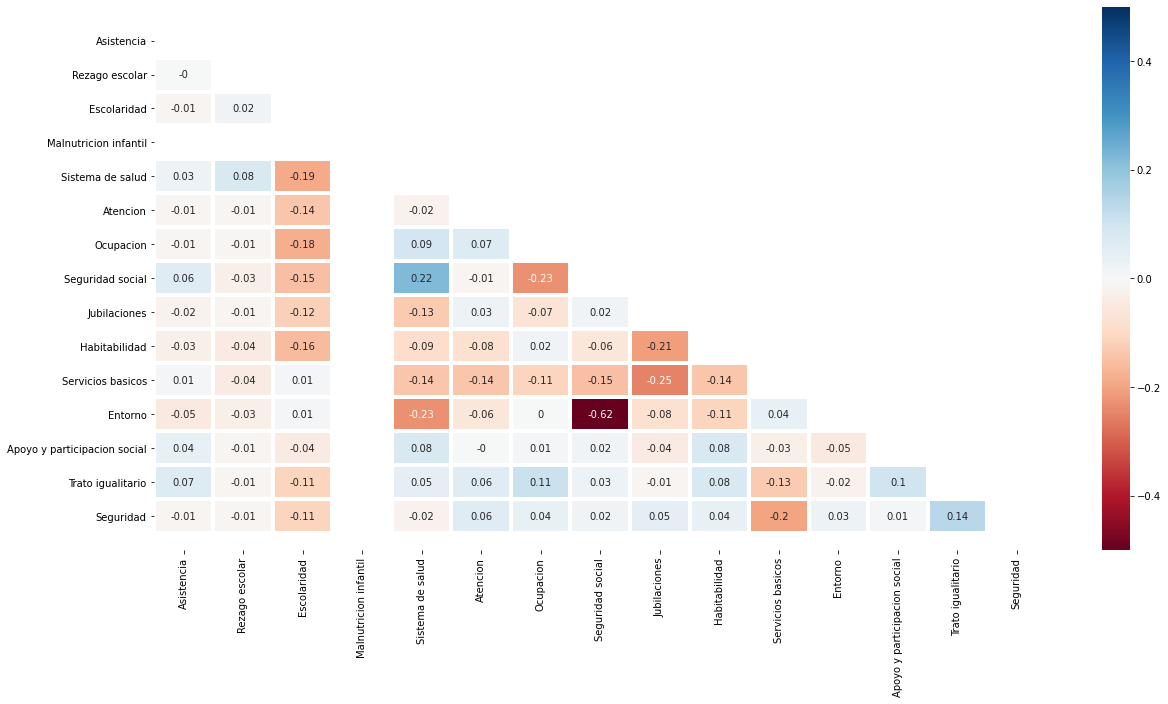

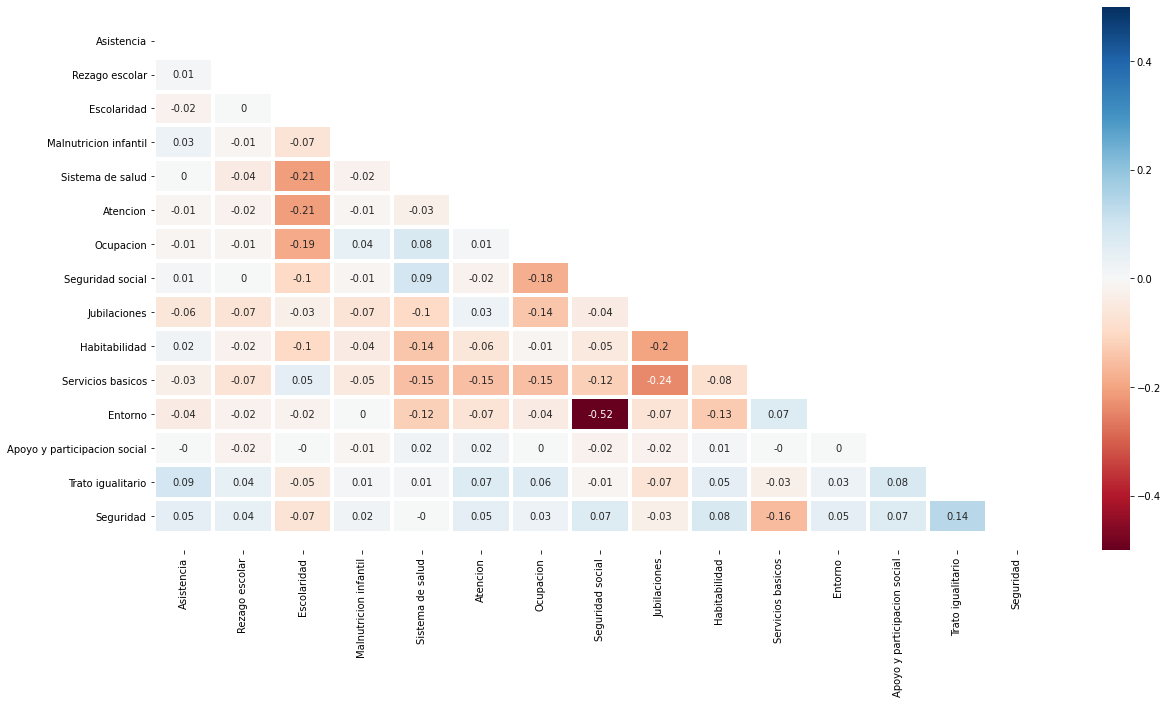

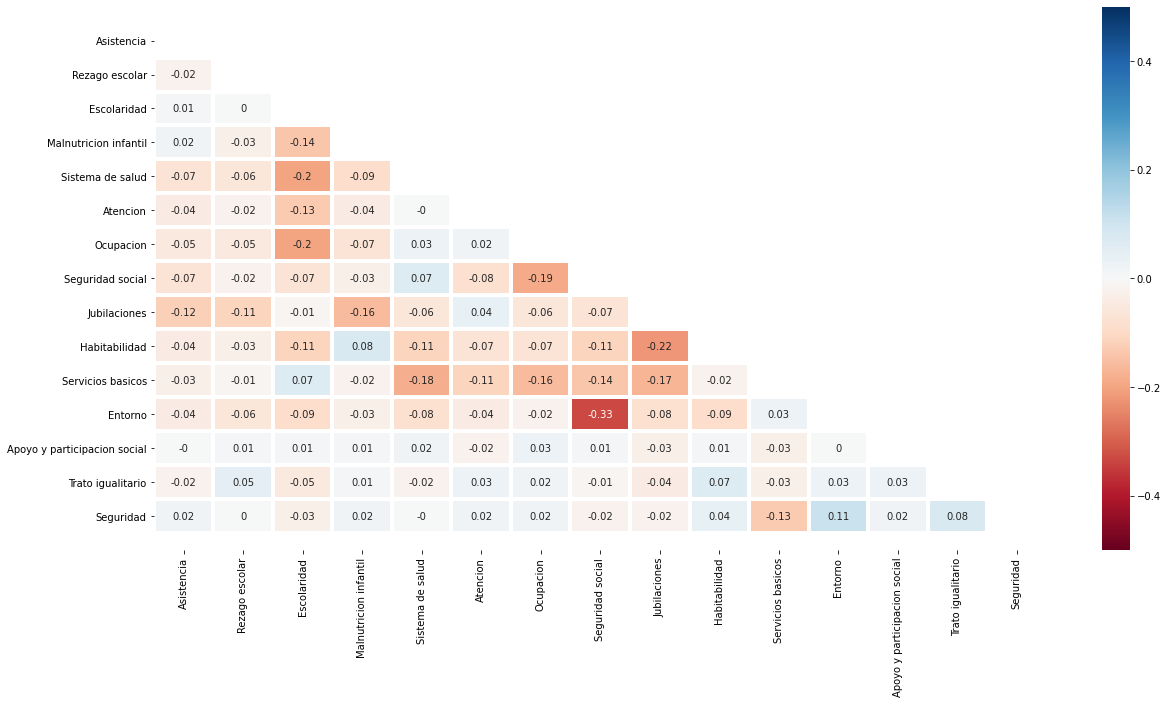

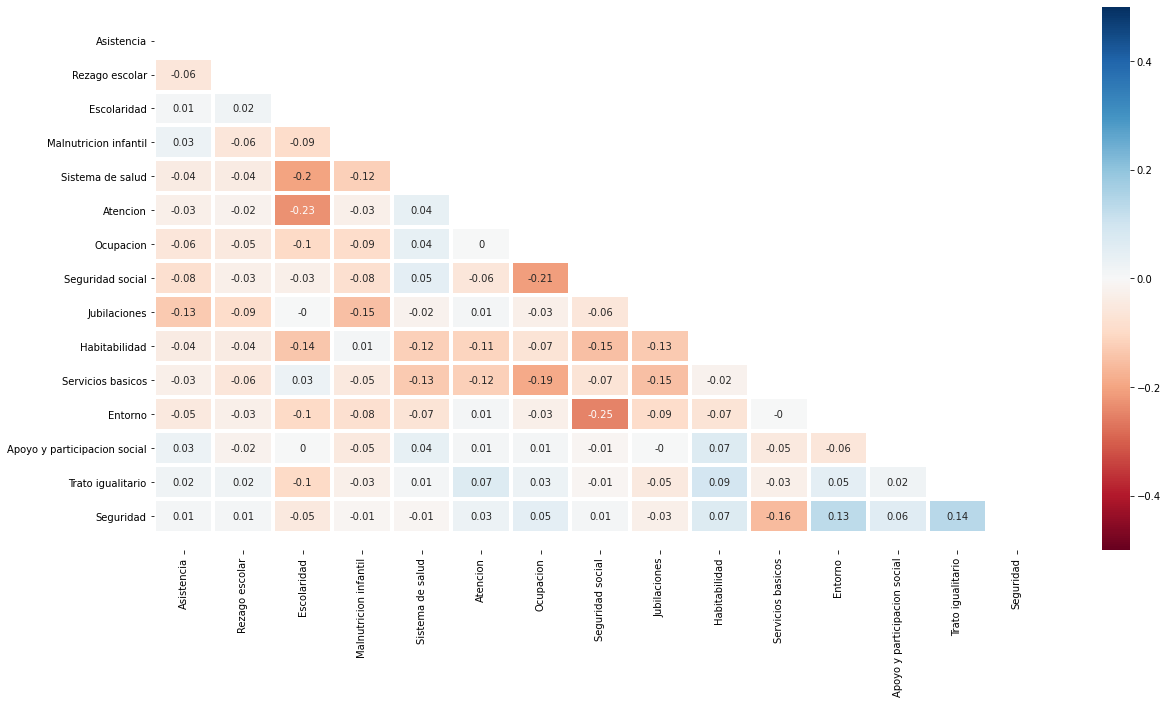

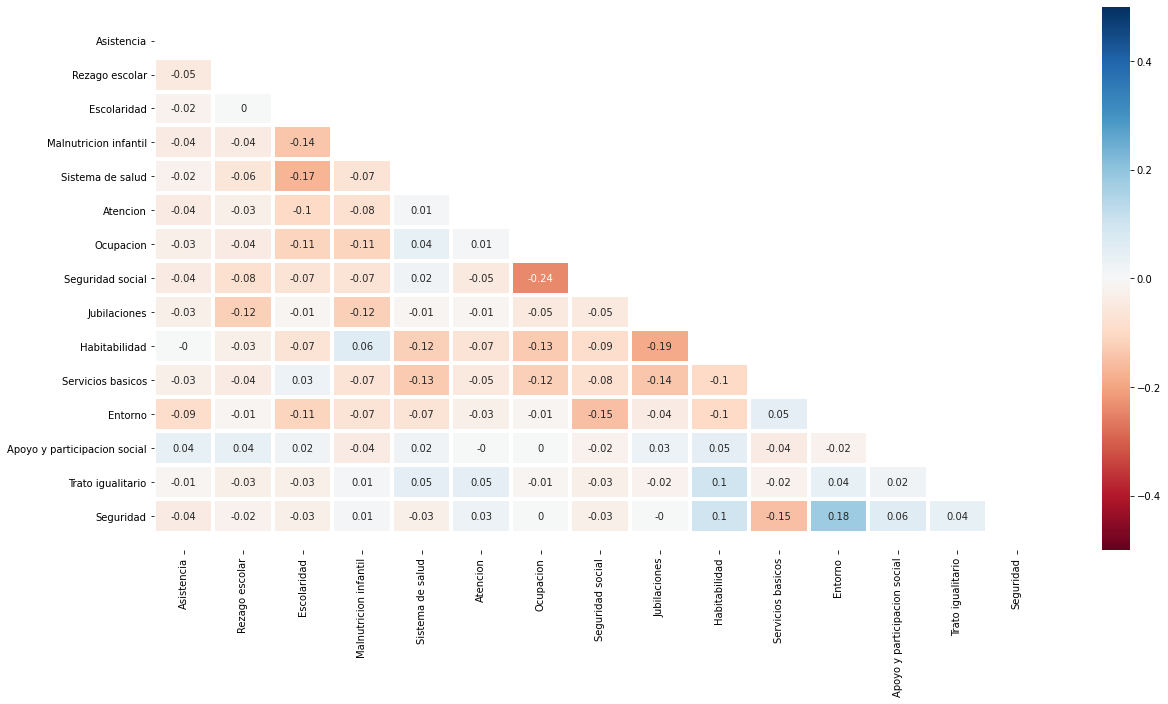

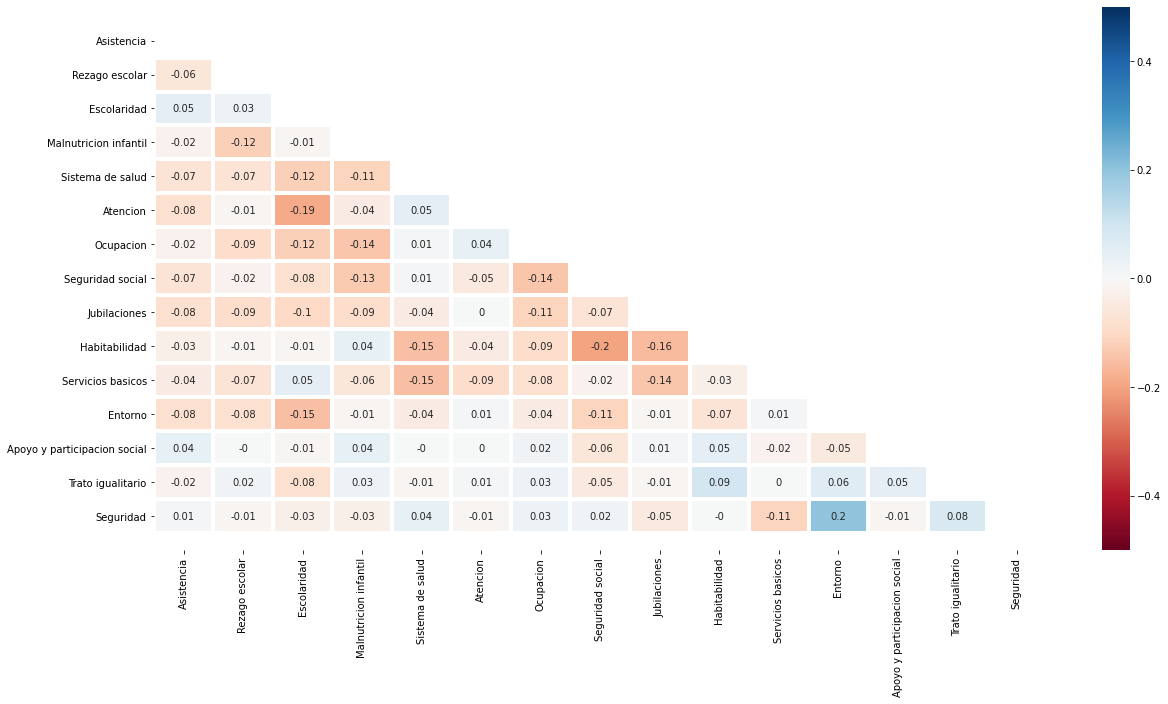

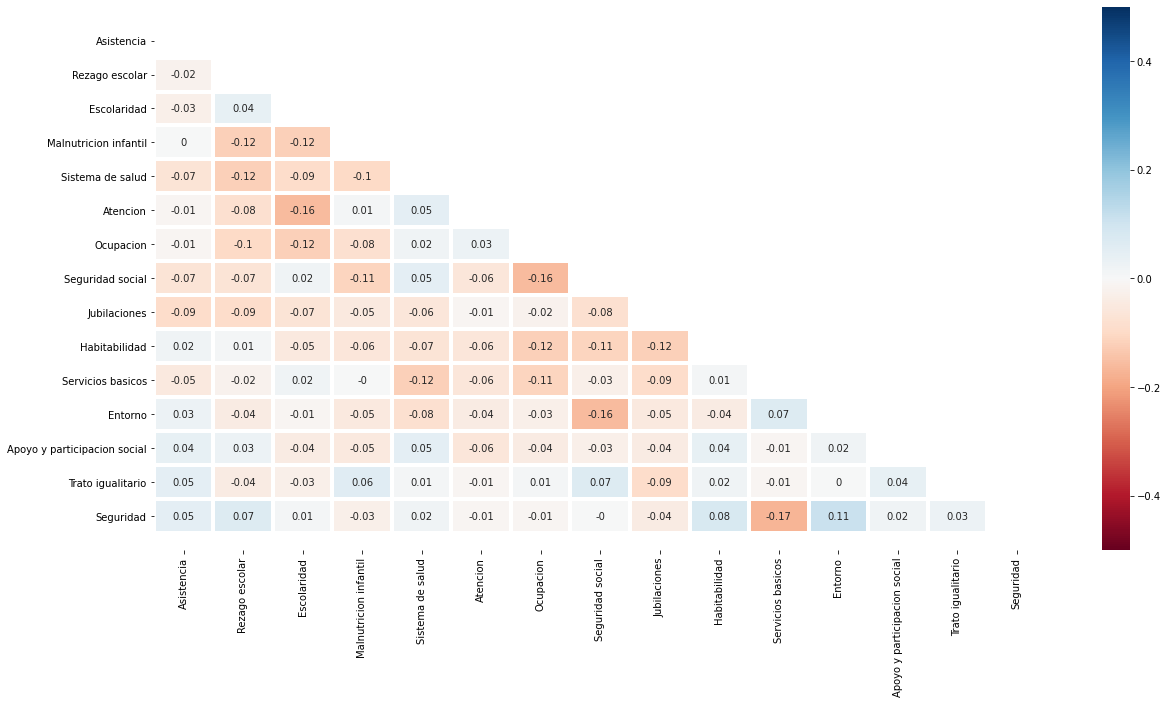

In [0]:
casen_n1 = casen_n1.drop(['numper'],axis=1)

# numper = 1
casen_n1=casen_numper[casen_numper.numper == 1]
casen_n1 = casen_n1.drop(['numper'],axis=1)
pearson_n1 = casen_n1.corr(method='pearson')
creacion_heatmap("pearson",casen_n1,True,"casen_n1")
pearson_n1.to_excel(excel_writer = "corr_n1.xlsx")

# numper = 2
casen_n2=casen_numper[casen_numper.numper == 2]
casen_n2 = casen_n2.drop(['numper'],axis=1)
pearson_n2 = casen_n2.corr(method='pearson')
creacion_heatmap("pearson",casen_n2,True,"casen_n2")
pearson_n2.to_excel(excel_writer = "corr_n2.xlsx")

# numper = 3
casen_n3=casen_numper[casen_numper.numper == 3]
casen_n3 = casen_n3.drop(['numper'],axis=1)
pearson_n3 = casen_n3.corr(method='pearson')
creacion_heatmap("pearson",casen_n3,True,"casen_n3")
pearson_n3.to_excel(excel_writer = "corr_n3.xlsx")

# numper = 4
casen_n4=casen_numper[casen_numper.numper == 4]
casen_n4 = casen_n4.drop(['numper'],axis=1)
pearson_n4 = casen_n4.corr(method='pearson')
creacion_heatmap("pearson",casen_n4,True,"casen_n4")
pearson_n4.to_excel(excel_writer = "corr_n4.xlsx")

# numper = 5
casen_n5=casen_numper[casen_numper.numper == 5]
casen_n5 = casen_n5.drop(['numper'],axis=1)
pearson_n5 = casen_n5.corr(method='pearson')
creacion_heatmap("pearson",casen_n5,True,"casen_n5")
pearson_n5.to_excel(excel_writer = "corr_n5.xlsx")

# numper = 6
casen_n6=casen_numper[casen_numper.numper == 6]
casen_n6 = casen_n6.drop(['numper'],axis=1)
pearson_n6 = casen_n6.corr(method='pearson')
creacion_heatmap("pearson",casen_n6,True,"casen_n6")
pearson_n6.to_excel(excel_writer = "corr_n6.xlsx")

# numper >= 7
casen_nmayor=casen_numper[casen_numper.numper >6]
casen_nmayor = casen_nmayor.drop(['numper'],axis=1)
pearson_nmayor = casen_nmayor.corr(method='pearson')
creacion_heatmap("pearson",casen_nmayor,True,"casen_nmayor")
pearson_nmayor.to_excel(excel_writer = "corr_nmayor.xlsx")




#6- Cálculo correlaciones por tipo de hogar



total de hogares = 12392
total de hogares = 12392
total de h. unipersonal = 1246 - 10.05 %
total de h. monoparental nuclear = 2180 - 17.59 %
total de h. biparental nuclear = 5804 - 46.84 %
total de h. monoparental extendido = 1202 - 9.7 %
total de h. biparental extendido = 1894 - 15.28 %
total de h. censal = 66 - 0.53 %


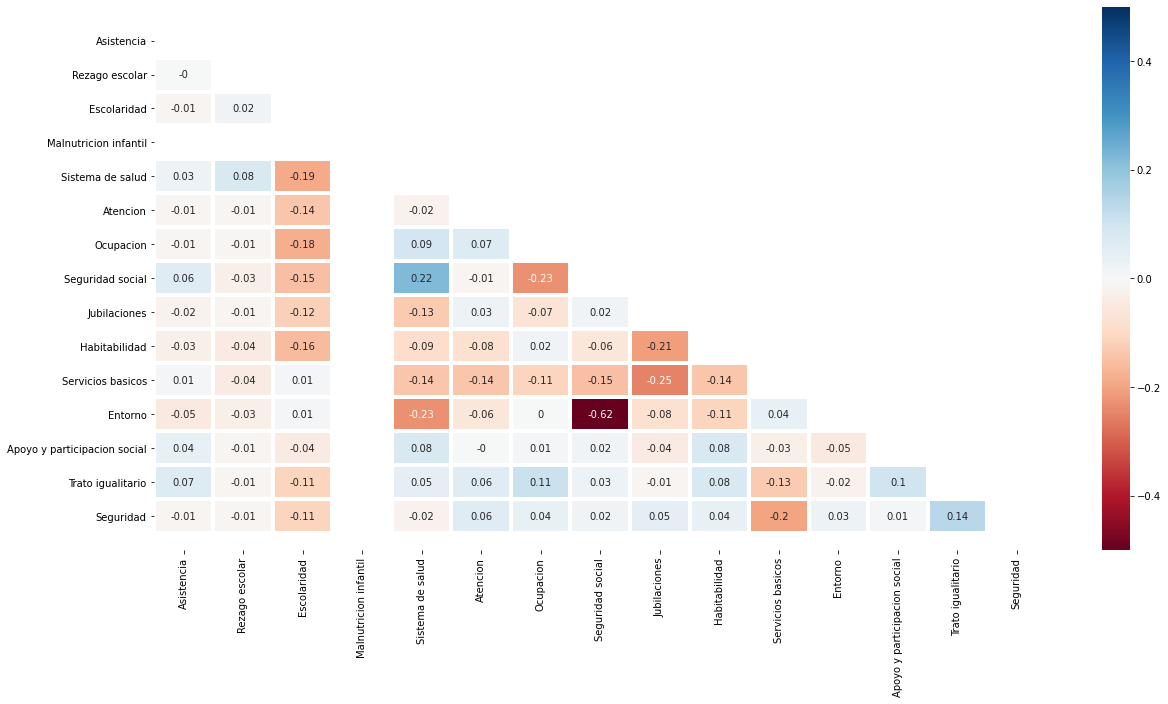

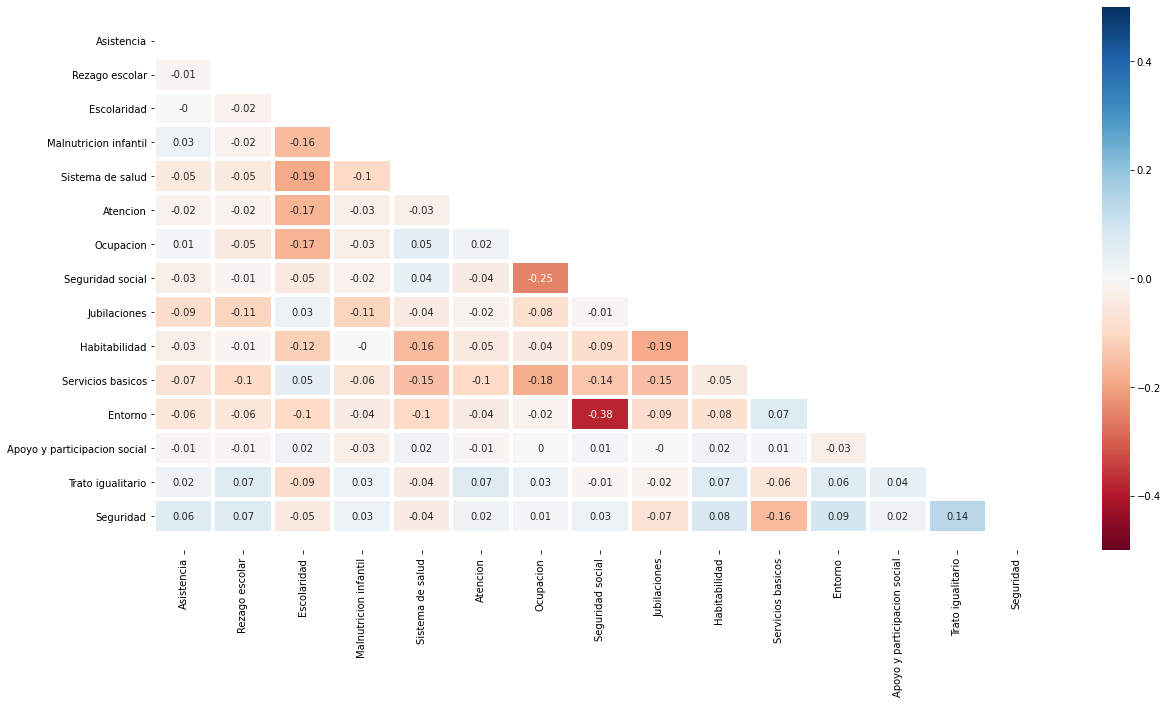

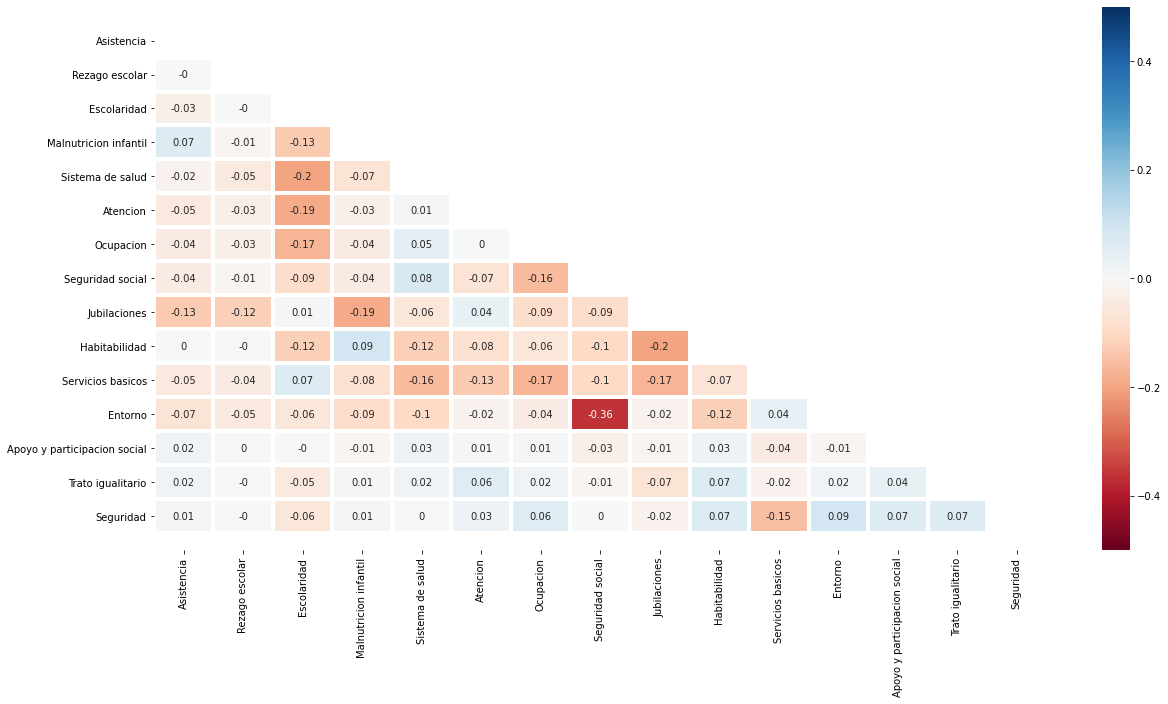

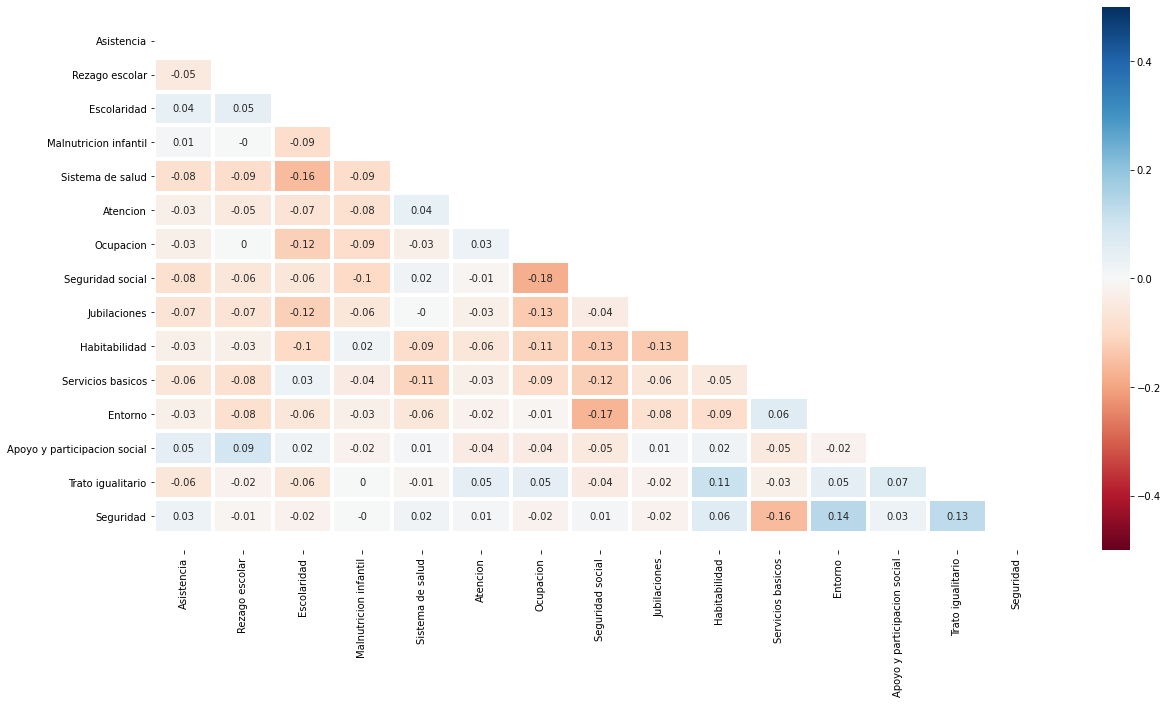

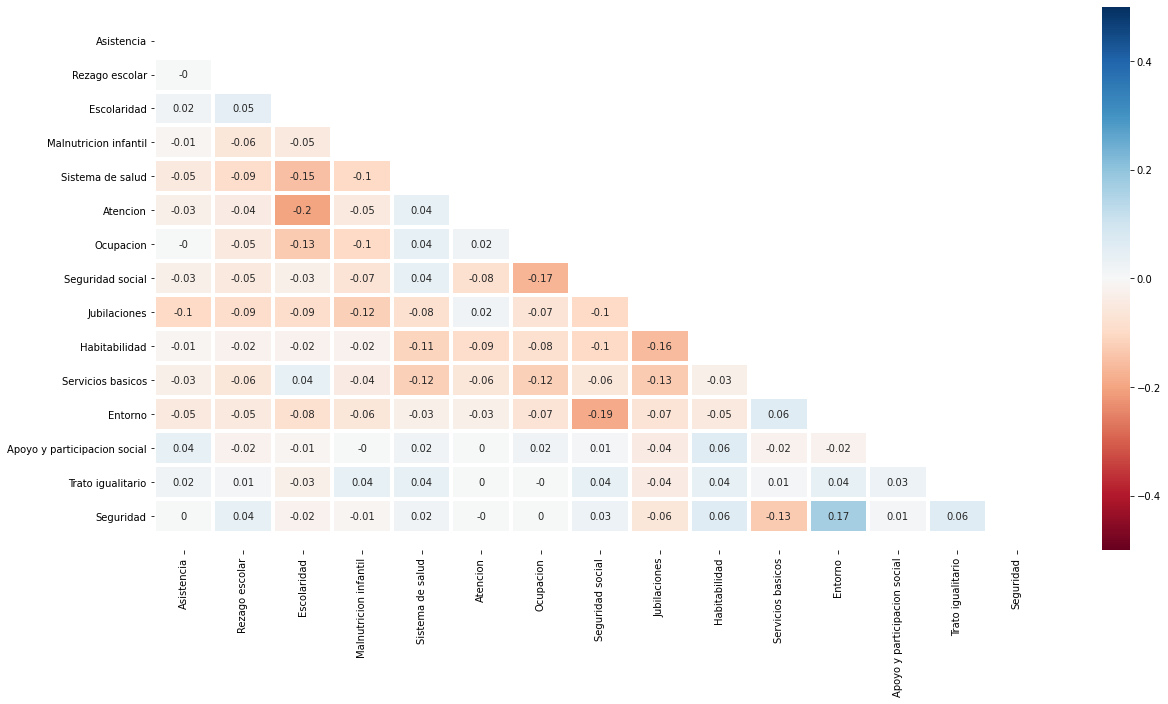

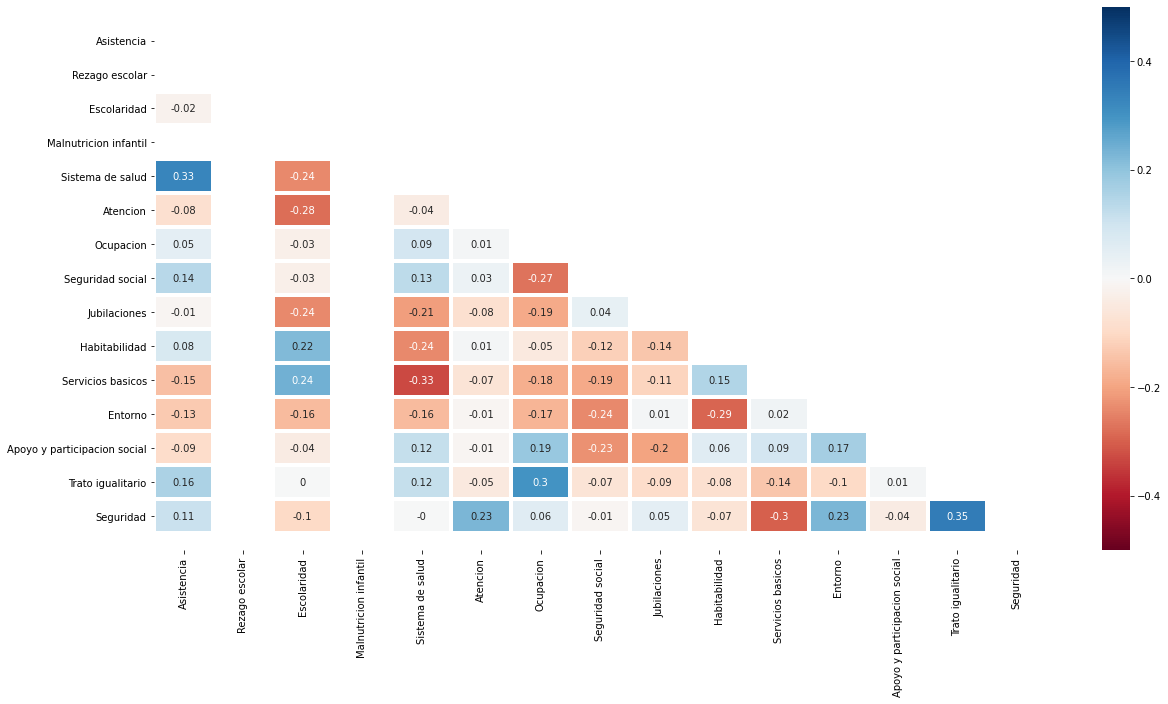

In [0]:
tipohogares=casen[["folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad","d"]]
tipohogares=tipohogares.drop_duplicates()
t_hogares=len(tipohogares.index)
print("total de hogares =",t_hogares)

hogar_unip=tipohogares[tipohogares.d == 1]
hogar_mononuc=tipohogares[tipohogares.d == 2]
hogar_binuc=tipohogares[tipohogares.d == 3]
hogar_monoex=tipohogares[tipohogares.d == 4]
hogar_biex=tipohogares[tipohogares.d == 5]
hogar_cen=tipohogares[tipohogares.d == 6]


hogar_unip=hogar_unip[jjj]
hogar_mononuc=hogar_mononuc[jjj]
hogar_binuc=hogar_binuc[jjj]
hogar_monoex=hogar_monoex[jjj]
hogar_biex=hogar_biex[jjj]
hogar_cen=hogar_cen[jjj]

t_unip=len(hogar_unip.index)
t_mononuc=len(hogar_mononuc.index)
t_binuc=len(hogar_binuc.index)
t_monoex=len(hogar_monoex.index)
t_biex=len(hogar_biex.index)
t_cen=len(hogar_cen.index)





print("total de hogares =",t_hogares)
print("total de h. unipersonal =",t_unip, "-",round(t_unip*100/t_hogares,2),"%")
print("total de h. monoparental nuclear =",t_mononuc,"-",round(t_mononuc*100/t_hogares,2),"%")
print("total de h. biparental nuclear =",t_binuc,"-",round(t_binuc*100/t_hogares,2),"%")
print("total de h. monoparental extendido =",t_monoex,"-",round(t_monoex*100/t_hogares,2),"%")
print("total de h. biparental extendido =",t_biex,"-",round(t_biex*100/t_hogares,2),"%")
print("total de h. censal =",t_cen,"-",round(t_cen*100/t_hogares,2),"%")


creacion_heatmap("pearson",hogar_unip,True,"car_unip")
creacion_heatmap("pearson",hogar_mononuc,True,"car_monoc")
creacion_heatmap("pearson",hogar_binuc,True,"car_binuc")
creacion_heatmap("pearson",hogar_monoex,True,"car_monoex")
creacion_heatmap("pearson",hogar_biex,True,"car_biex")
creacion_heatmap("pearson",hogar_cen,True,"car_censal")


In [0]:
print(len(tipohogares.index))

12392


#7- Cálculo correlaciones dimensionales (5D)



In [0]:
# Calculo de indicador por dimension

dim=tipohogares.copy()
dim["Educacion"]=np.nan
dim["Salud"]=np.nan
dim["Trabajo y seguridad social"]=np.nan
dim["Vivienda y entorno"]=np.nan
dim["Redes y cohesion social"]=np.nan

for p in dim.index:
 # dim[p,"Educacion"]=dim[p,"Asistencia"]
  
  dim['Educacion'][p]=dim['Asistencia'][p]+dim['Rezago escolar'][p]+dim['Escolaridad'][p]
  dim['Salud'][p]=dim['Malnutricion infantil'][p]+dim['Sistema de salud'][p]+dim['Atencion'][p]
  dim['Trabajo y seguridad social'][p]=dim['Ocupacion'][p]+dim['Seguridad social'][p]+dim['Jubilaciones'][p]
  dim['Vivienda y entorno'][p]=dim['Habitabilidad'][p]+dim['Servicios basicos'][p]+dim['Entorno'][p]
  dim['Redes y cohesion social'][p]=dim['Apoyo y participacion social'][p]+dim['Trato igualitario'][p]+dim['Seguridad'][p]
  dim["Educacion"][p]=int(dim["Educacion"][p])
#dim[dim.Educacion == 3]
dim1=dim[["folio","Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social","d"]]

#casen_hogares=casen[["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_l

In [0]:
dim2=dim1.drop(['d'],axis=1)
dim2=dim2.drop_duplicates()
dim2=dim2.drop(['folio'],axis=1)
pearsonDim = dim1.corr(method='pearson')
pearsonDim

,folio,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social,d
folio,1.000000,0.015896,0.015483,0.021342,-0.035241,0.024977,0.015478
Educacion,0.015896,1.000000,-0.232382,-0.189302,-0.139436,-0.024152,0.097277
Salud,0.015483,-0.232382,1.000000,-0.042665,-0.268346,0.043461,0.144565
Trabajo y seguridad social,0.021342,-0.189302,-0.042665,1.000000,-0.507549,-0.003020,0.200207
Vivienda y entorno,-0.035241,-0.139436,-0.268346,-0.507549,1.000000,0.018705,-0.232363
Redes y cohesion social,0.024977,-0.024152,0.043461,-0.003020,0.018705,1.000000,0.024286
d,0.015478,0.097277,0.144565,0.200207,-0.232363,0.024286,1.000000


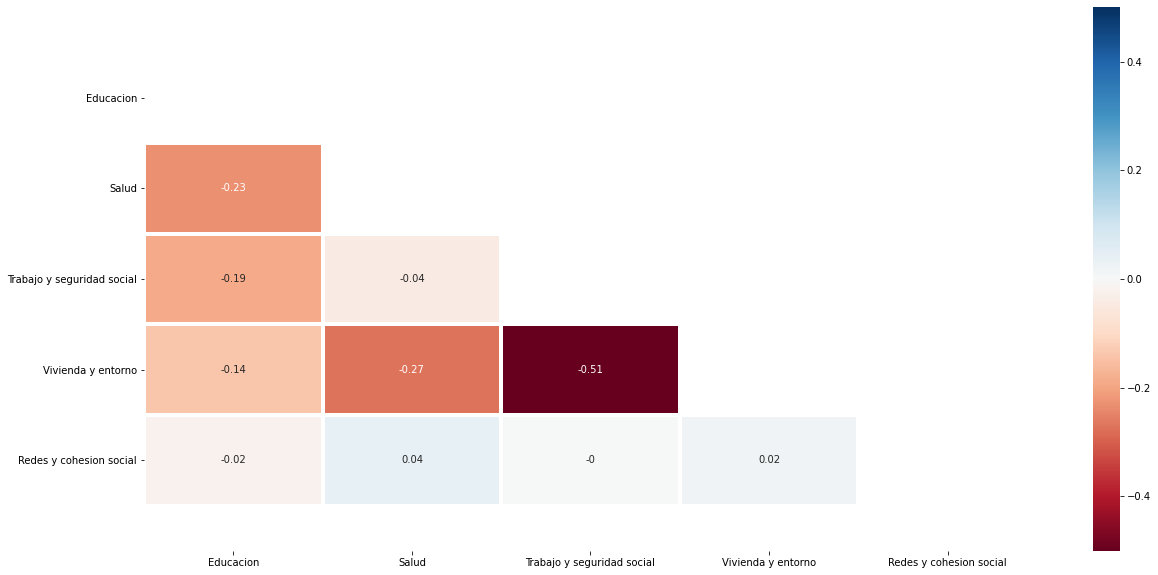

In [0]:
# OBTENCION HEATMAPS PEARSON, KENDALL Y SPEARMAN POR DIMENSIONES

creacion_heatmap("pearson",dim2,True,"DIM_entrega1")


In [0]:
# exportacion datos correlaciones excel

pearsonDim.to_excel(excel_writer = "pearsonDim.xlsx")
dim.to_excel(excel_writer="hola.xlsx")


#8- Cálculo correlaciones dimensionales por hogar



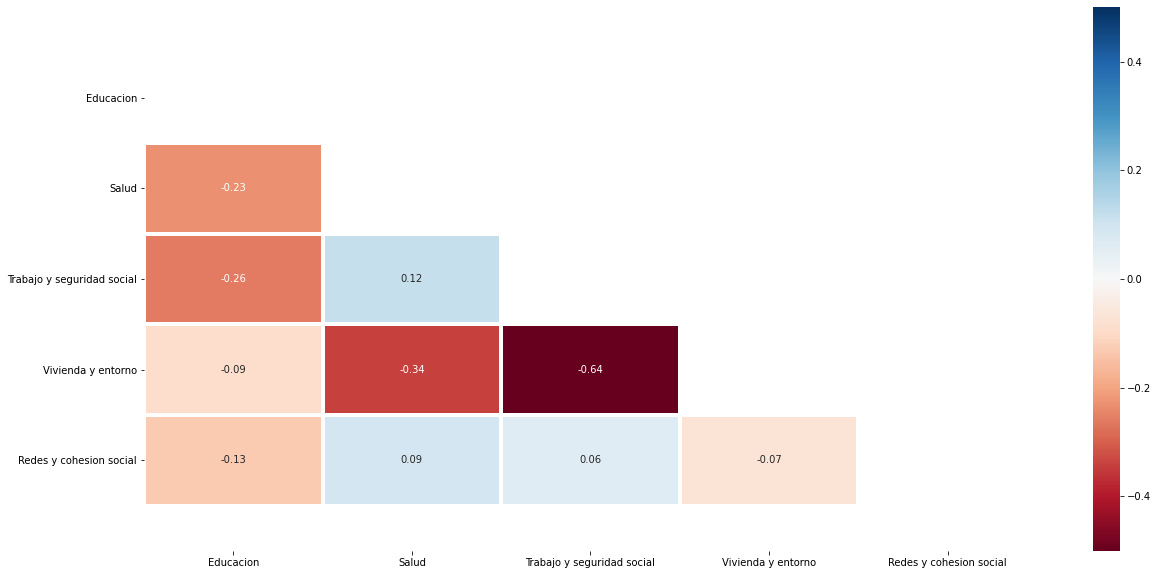

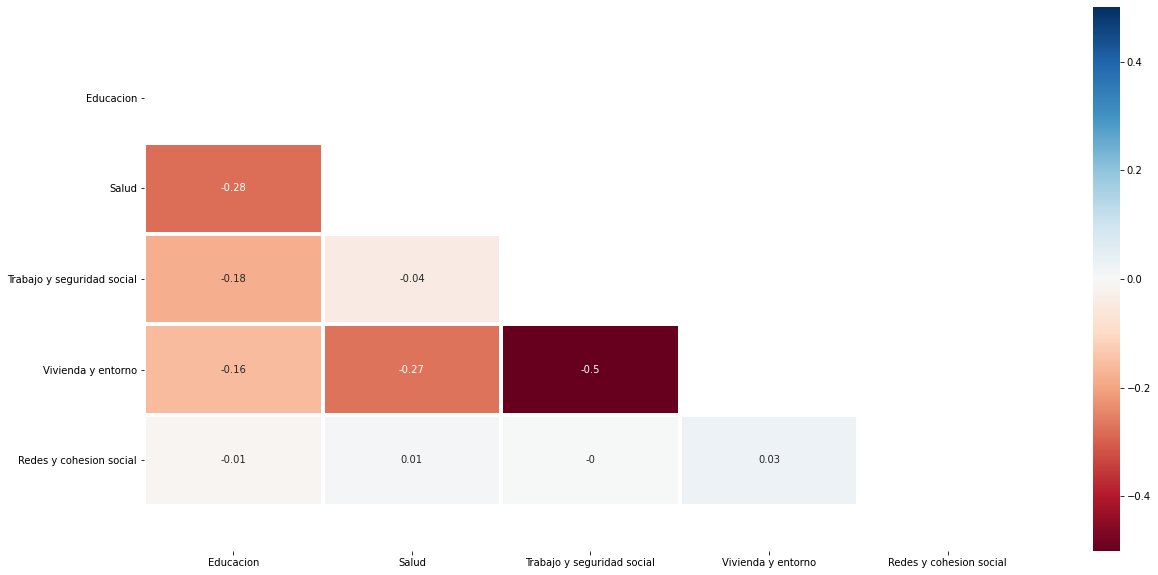

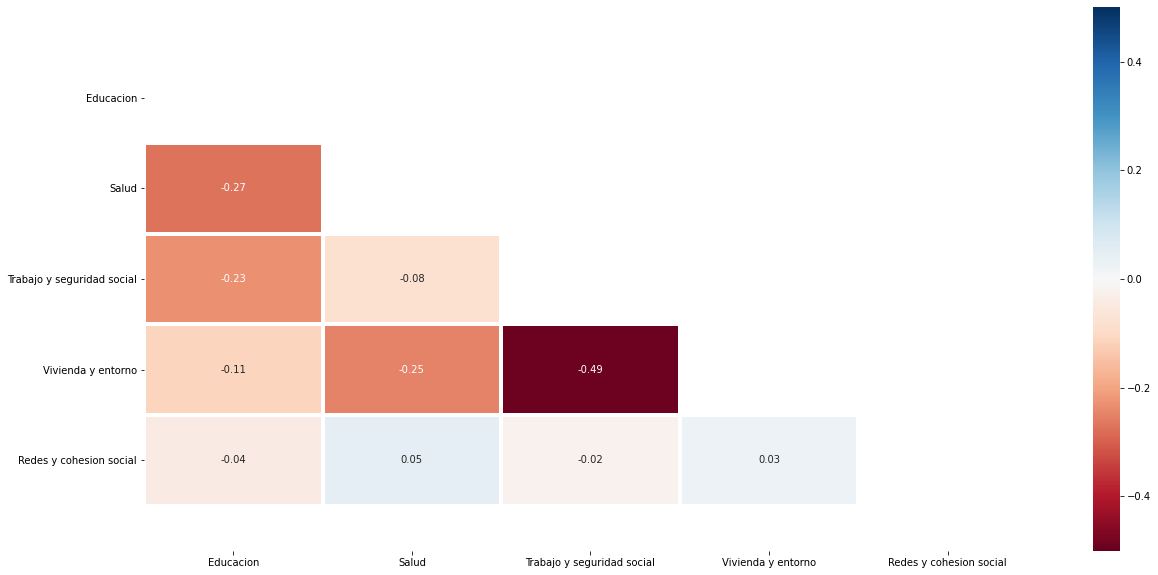

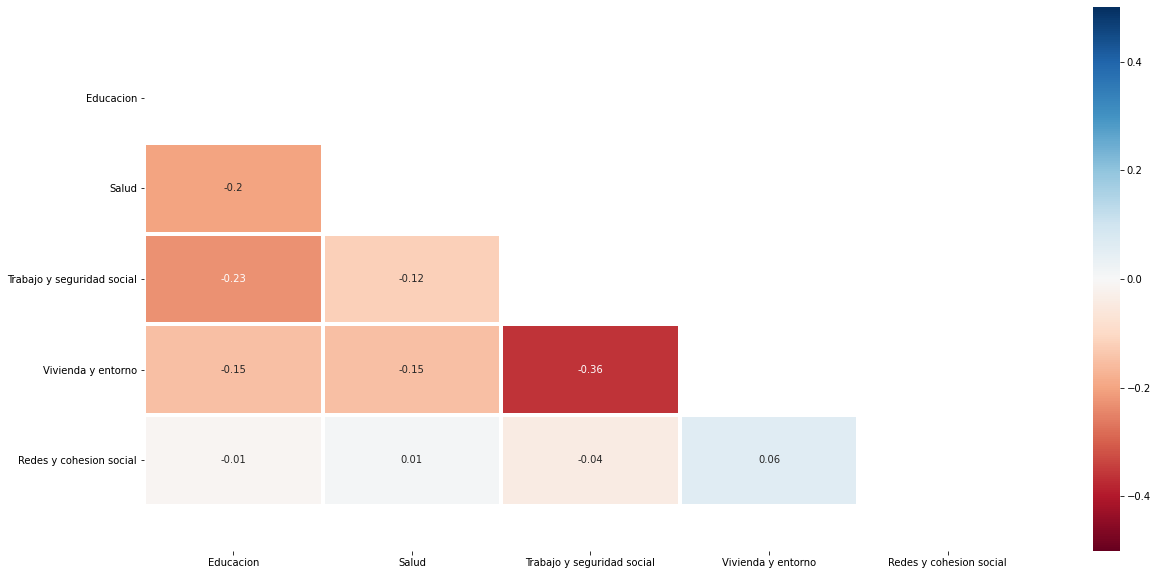

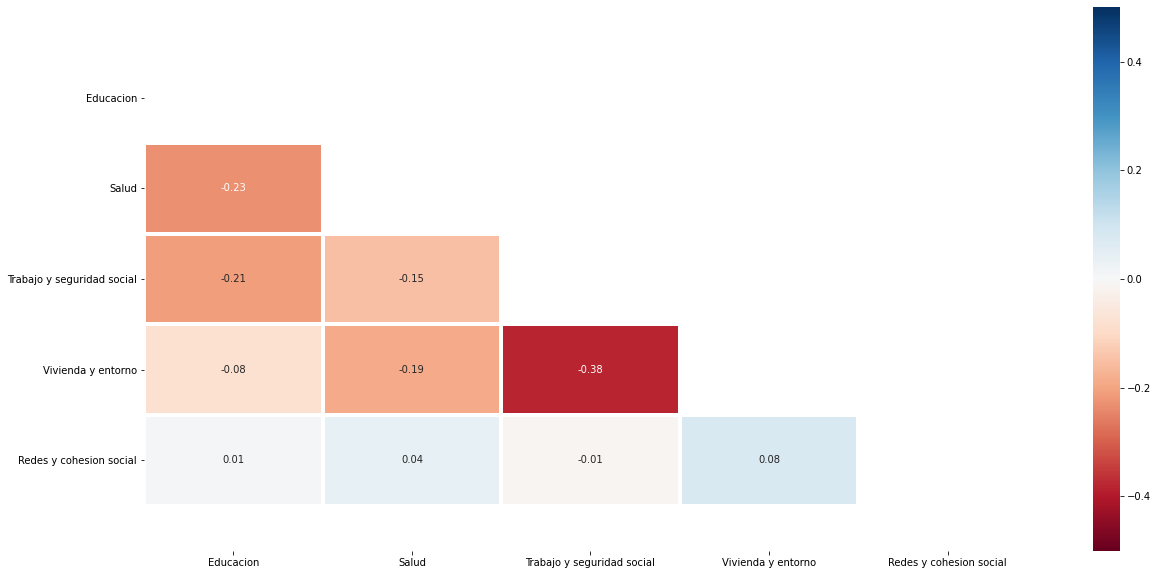

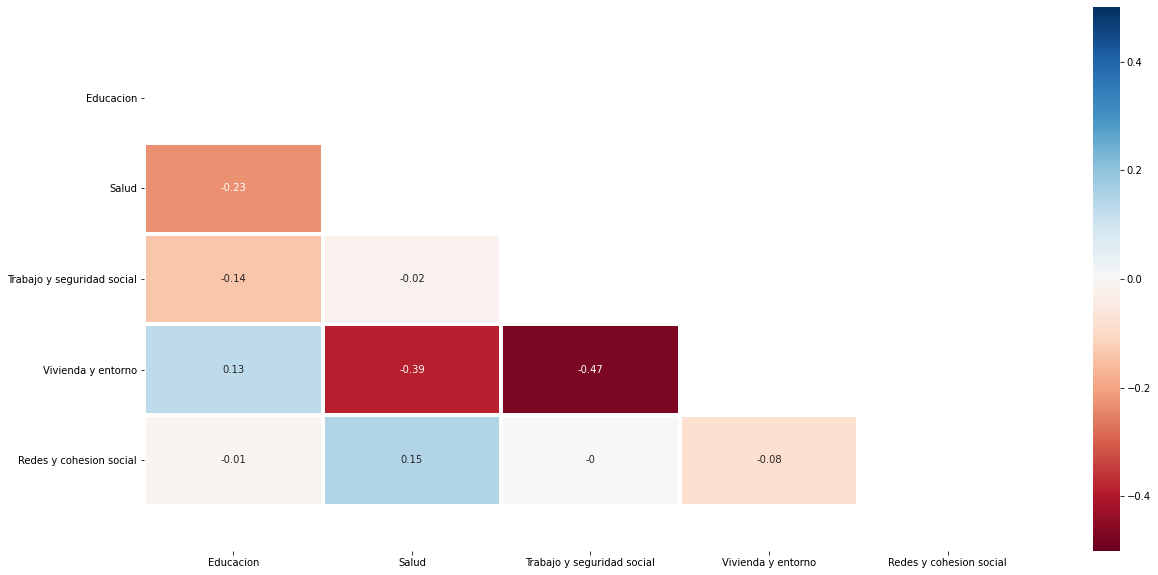

In [0]:
dim3=dim1.drop_duplicates()

dim31=dim3[dim3.d==1].drop("d", axis=1)
dim31=dim31.drop("folio", axis=1)

dim32=dim3[dim3.d==2].drop("d", axis=1)
dim32=dim32.drop("folio", axis=1)

dim33=dim3[dim3.d==3].drop("d", axis=1)
dim33=dim33.drop("folio", axis=1)

dim34=dim3[dim3.d==4].drop("d", axis=1)
dim34=dim34.drop("folio", axis=1)

dim35=dim3[dim3.d==5].drop("d", axis=1)
dim35=dim35.drop("folio", axis=1)

dim36=dim3[dim3.d==6].drop("d", axis=1)
dim36=dim36.drop("folio", axis=1)

creacion_heatmap("pearson",dim31,True,"dim_unip")
creacion_heatmap("pearson",dim32,True,"dim_monuc")
creacion_heatmap("pearson",dim33,True,"dim_binuc")
creacion_heatmap("pearson",dim34,True,"dim_moex")
creacion_heatmap("pearson",dim35,True,"dim_biex")
creacion_heatmap("pearson",dim36,True,"dim_cen")

#10- Cálculo coeficiente de determinación R cuadrado para dimensiones


In [0]:
dim.head()

,folio,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,d,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
1,110110020301,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1.0,1.0,1.0,0.0
7,110110020601,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2,1.0,0.0,3.0,2.0,2.0
19,110110030401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,0.0,0.0,1.0,3.0,2.0
26,110110040201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1,0.0,0.0,1.0,2.0,2.0
41,110110050501,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,0.0,1.0,0.0,2.0,1.0


In [0]:
dimensiones2=dim.T
dimensiones2.head()

,1,7,19,26,41,44,49,53,60,68,81,143,175,240,259,264,289,292,315,325,328,344,352,366,374,386,419,421,437,454,455,460,500,510,512,539,660,663,696,699,...,216237,216239,216243,216259,216261,216266,216273,216297,216326,216332,216335,216344,216351,216360,216363,216371,216374,216376,216378,216382,216384,216386,216389,216391,216393,216395,216397,216398,216399,216400,216404,216411,216422,216423,216425,216426,216428,216433,216434,216436
folio,1.101100e+11,1.101100e+11,1.101100e+11,1.101100e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101102e+11,1.101103e+11,1.101103e+11,1.101103e+11,1.101103e+11,1.101103e+11,1.101103e+11,1.101103e+11,1.101103e+11,1.101103e+11,1.101103e+11,1.101103e+11,...,1.510230e+12,1.510230e+12,1.510230e+12,1.510230e+12,1.510230e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520120e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12
Asistencia,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Rezago escolar,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Escolaridad,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.

In [0]:
# cálculo coef. 
dimensionesR=np.corrcoef(dimensiones2)

In [0]:
pd.DataFrame(dimensionesR).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.000000,-0.007508,-0.005547,0.028288,0.005567,0.020728,-0.004321,0.000955,0.037980,-0.009369,-0.033922,-0.010720,-0.014042,0.000242,-0.015604,0.062659,0.015478,0.015896,0.015483,0.021342,-0.035241,0.024977
1,-0.007508,1.000000,0.001807,-0.001669,0.057216,-0.035233,-0.033008,-0.000002,-0.023322,-0.093290,-0.013697,-0.072353,-0.075101,0.021848,0.014863,0.028150,0.099429,0.458625,-0.005743,-0.075341,-0.092922,0.034571
2,-0.005547,0.001807,1.000000,0.011478,-0.003866,-0.053011,-0.027417,-0.015600,-0.009737,-0.096590,-0.015257,-0.081555,-0.065003,0.005373,0.012865,0.026042,0.073640,0.445717,-0.052220,-0.077050,-0.093655,0.024680
3,0.028288,-0.001669,0.011478,1.000000,-0.095546,-0.185647,-0.170200,-0.148758,-0.077000,-0.025015,-0.101716,0.043571,-0.062650,-0.001392,-0.063631,-0.047749,0.025369,0.773535,-0.269044,-0.157434,-0.072708,-0.066017
4,0.005567,0.057216,-0.003866,-0.095546,1.000000,-0.078169,-0.035771,-0.028609,-0.023408,-0.120435,0.029542,-0.098659,-0.088984,-0.014239,0.012719,0.020964,0.197056,-0.048920,0.534783,-0.109379,-0.089207,0.012863


In [0]:
# obtención coef. r cuadrado
dimensionesR2=dimensionesR**2

In [0]:
dimensionesR2=pd.DataFrame(dimensionesR2)
dimensionesR2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.000000,0.000056,0.000031,0.000800,0.000031,0.000430,0.000019,9.120145e-07,0.001443,0.000088,0.001151,0.000115,0.000197,5.858986e-08,0.000243,0.003926,0.000240,0.000253,0.000240,0.000455,0.001242,0.000624
1,0.000056,1.000000,0.000003,0.000003,0.003274,0.001241,0.001090,3.681132e-12,0.000544,0.008703,0.000188,0.005235,0.005640,4.773180e-04,0.000221,0.000792,0.009886,0.210337,0.000033,0.005676,0.008635,0.001195
2,0.000031,0.000003,1.000000,0.000132,0.000015,0.002810,0.000752,2.433522e-04,0.000095,0.009330,0.000233,0.006651,0.004225,2.887179e-05,0.000166,0.000678,0.005423,0.198663,0.002727,0.005937,0.008771,0.000609
3,0.000800,0.000003,0.000132,1.000000,0.009129,0.034465,0.028968,2.212880e-02,0.005929,0.000626,0.010346,0.001898,0.003925,1.937522e-06,0.004049,0.002280,0.000644,0.598357,0.072384,0.024785,0.005286,0.004358
4,0.000031,0.003274,0.000015,0.009129,1.000000,0.006110,0.001280,8.184581e-04,0.000548,0.014505,0.000873,0.009734,0.007918,2.027620e-04,0.000162,0.000440,0.038831,0.002393,0.285993,0.011964,0.007958,0.000165


In [0]:
pd.DataFrame(dimensionesR).to_excel(excel_writer = "r.xlsx")
dimensionesR2.to_excel(excel_writer = "r_cuadrado.xlsx")

In [0]:
dim.cov()

,folio,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,d,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
folio,1.426639e+23,-7.333556e+08,-5.146183e+08,4.629773e+09,6.703526e+08,2.828216e+09,-4.220187e+08,1.467741e+08,6.976381e+09,-1.546774e+09,-6.402214e+09,-1.908081e+09,-2.378255e+09,2.474284e+07,-2.152928e+09,7.733289e+09,6.749225e+09,3.381799e+09,3.076550e+09,5.576382e+09,-1.068855e+10,5.605104e+09
Asistencia,-7.333556e+08,6.687500e-02,1.147580e-04,-1.870409e-04,4.717528e-03,-3.291400e-03,-2.207402e-03,-2.018896e-07,-2.932954e-03,-1.054504e-02,-1.769855e-03,-8.817554e-03,-8.708280e-03,1.529034e-03,1.403999e-03,2.378637e-03,2.968410e-02,6.680271e-02,-7.812736e-04,-1.347819e-02,-1.929569e-02,5.311670e-03
Rezago escolar,-5.146183e+08,1.147580e-04,6.032466e-02,1.221601e-03,-3.027107e-04,-4.703428e-03,-1.741428e-03,-1.559037e-03,-1.163060e-03,-1.036950e-02,-1.872389e-03,-9.439752e-03,-7.158731e-03,3.571622e-04,1.154268e-03,2.090026e-03,2.088046e-02,6.166102e-02,-6.747567e-03,-1.309160e-02,-1.847087e-02,3.601456e-03
Escolaridad,4.629773e+09,-1.870409e-04,1.221601e-03,1.877570e-01,-1.319998e-02,-2.905934e-02,-1.907172e-02,-2.622819e-02,-1.622567e-02,-4.737867e-03,-2.202321e-02,8.897366e-03,-1.217235e-02,-1.632310e-04,-1.007171e-02,-6.760618e-03,1.269065e-02,1.887916e-01,-6.133104e-02,-4.719173e-02,-2.529820e-02,-1.699556e-02
Malnutricion infantil,6.703526e+08,4.717528e-03,-3.027107e-04,-1.319998e-02,1.016539e-01,-9.003234e-03,-2.949327e-03,-3.711519e-03,-3.629499e-03,-1.678396e-02,4.706502e-03,-1.482387e-02,-1.272135e-02,-1.228674e-03,1.481303e-03,2.184068e-03,7.253221e-02,-8.785167e-03,8.970137e-02,-2.412498e-02,-2.283872e-02,2.436697e-03
Sistema de salud,2.828216e+09,-3.291400e-03,-4.703428e-03,-2.905934e-02,-9.003234e-03,1.304973e-01,8.244910e-04,6.586186e-03,1.361179e-02,-9.501419e-03,-2.212726e-02,-2.505520e-02,-1.637708e-02,2.975306e-03,1.679774e-03,-1.908964e-04,8.343537e-03,-3.705416e-02,1.223185e-01,1.069655e-02,-6.355953e-02,4.464183e-03
Atencion,-4.220187e+08,-2.207402e-03,-1.741428e-03,-1.907172e-02,-2.949327e-03,8.244910e-04,6.687500e-02,1.775280e-03,-6.161104e-03,2.286856e-03,-1.000164e-02,-1.325626e-02,-3.704648e-03,-8.504111e-05,4.551445e-03,2.217230e-03,6.925647e-03,-2.302055e-02,6.475016e-02,-2.098968e-03,-2.696254e-02,6.683633e-03
Ocupacion,1.467741e+08,-2.018896e-07,-1.559037e-03,-2.622819e-02,-3.711519e-03,6.586186e-03,1.775280e-03,1.655704e-01,-3.189886e-02,-1.383161e-02,-1.357803e-02,-3.492965e-02,-1.067708e-02,6.877923e-04,4.964146e-03,5.215850e-03,6.221813e-02,-2.778743e-02,4.649947e-03,1.198399e-01,-5.918476e-02,1.086779e-02
Seguridad social,6.976381e+09,-2.932954e-03,-1.163060e-03,-1.622567e-02,-3.629499e-03,1.361179e-02,-6.161104e-03,-3.189886e-02,2.364970e-01,-1.154865e-02,-2.477709e-02,-3.068149e-02,-8.002965e-02,-2.070593e-03,-1.613619e-04,3.298785e-03,5.939772e-02,-2.032169e-02,3.821184e-03,1.930494e-01,-1.354882e-01,1.066830e-03
Jubilaciones,-1.546774e+09,-1.054504e-02,-1.036950e-02,-4.737867e-03,-1.678396e-02,-9.501419e-03,2.286856e-03,-1.383161e-02,-1.154865e-02,1.910549e-01,-4.205774e-02,-3.388556e-02,-1.132328e-02,-2.064523e-03,-7.292610e-03,-3.818592e-03,3.827730e-02,-2.565240e-02,-2.399852e-02,1.656746e-01,-8.726659e-02,-1.317573e-02


#11- Obtención tipologías




In [0]:
# calculo frecuencia de cada carencia
suma_carencias=casen_hogares.sum()
suma_carencias


Asistencia                       893.0
Rezago escolar                   799.0
Escolaridad                     9288.0
Malnutricion infantil           1423.0
Sistema de salud                1912.0
Atencion                         893.0
Ocupacion                       2595.0
Seguridad social                7637.0
Jubilaciones                    3187.0
Habitabilidad                   6424.0
Servicios basicos               4125.0
Entorno                         3454.0
Apoyo y participacion social     986.0
Trato igualitario               1965.0
Seguridad                       1506.0
dtype: float64

In [0]:
# dataframe con factores externos

f1="zona" #numero de personas en el hogar
f2="numper" #rural o urbano
f3="ypc"
casen_tip=casen[[f1,f2,f3,"folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad","d"]]
casen_tip=casen_tip.drop_duplicates()
casen_tip=casen_tip.drop("folio",axis=1)
#casen_tip.head()

casen_tip_dim=casen_tip.copy()
casen_tip_dim["Educacion"]=np.nan
casen_tip_dim["Salud"]=np.nan
casen_tip_dim["Trabajo y seguridad social"]=np.nan
casen_tip_dim["Vivienda y entorno"]=np.nan
casen_tip_dim["Redes y cohesion social"]=np.nan

for p in casen_tip_dim.index:
 # dim[p,"Educacion"]=dim[p,"Asistencia"]
  
  casen_tip_dim['Educacion'][p]=casen_tip_dim['Asistencia'][p]+casen_tip_dim['Rezago escolar'][p]+casen_tip_dim['Escolaridad'][p]
  casen_tip_dim['Salud'][p]=casen_tip_dim['Malnutricion infantil'][p]+casen_tip_dim['Sistema de salud'][p]+casen_tip_dim['Atencion'][p]
  casen_tip_dim['Trabajo y seguridad social'][p]=casen_tip_dim['Ocupacion'][p]+casen_tip_dim['Seguridad social'][p]+casen_tip_dim['Jubilaciones'][p]
  casen_tip_dim['Vivienda y entorno'][p]=casen_tip_dim['Habitabilidad'][p]+casen_tip_dim['Servicios basicos'][p]+casen_tip_dim['Entorno'][p]
  casen_tip_dim['Redes y cohesion social'][p]=casen_tip_dim['Apoyo y participacion social'][p]+casen_tip_dim['Trato igualitario'][p]+casen_tip_dim['Seguridad'][p]


casen_tip_dim=casen_tip_dim[[f1,f2,"Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social"]]
casen_tip_dim.head()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to b

,zona,numper,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
1,Urbano,1.0,1.0,1.0,1.0,1.0,0.0
7,Urbano,2.0,1.0,0.0,3.0,2.0,2.0
19,Urbano,1.0,0.0,0.0,1.0,3.0,2.0
26,Urbano,1.0,0.0,0.0,1.0,2.0,2.0
41,Urbano,3.0,0.0,1.0,0.0,2.0,1.0


In [0]:
#  tipologias por carencias
tipos1=casen_tip.copy()
total1=len(tipos1[jjj].drop_duplicates().index)
print("total tipos =",total1)
tipos11=casen_hogares.groupby(["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]).size()
tipos11.to_excel(excel_writer = "tipologias.xlsx")



total tipos = 1849


In [0]:
# tipologias por peso dimensional
print("total tipos =",len(casen_tip_dim.drop_duplicates().index))
tiposdim2=casen_tip_dim.groupby(["Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social"]).size()
tiposdim2.to_excel(excel_writer = "tipologias_dimensionales.xlsx")


total tipos = 1689


In [0]:
# tipologías por cuantiles

# paso 1: asignacion ponderación total
tipos2=casen_tip.copy()
tipos2["IntPob"]=np.nan
tipos2

mult1=7.5
mult2=(10/3)

for p in tipos2.index:
  c11=tipos2['Asistencia'][p]
  c12=tipos2['Rezago escolar'][p]
  c13=tipos2['Escolaridad'][p]
  c21=tipos2['Malnutricion infantil'][p]
  c22=tipos2['Sistema de salud'][p]
  c23=tipos2['Atencion'][p]
  c31=tipos2['Ocupacion'][p]
  c32=tipos2['Seguridad social'][p]
  c33=tipos2['Jubilaciones'][p]
  c41=tipos2['Habitabilidad'][p]
  c42=tipos2['Servicios basicos'][p]
  c43=tipos2['Entorno'][p]
  c51=tipos2['Apoyo y participacion social'][p]
  c52=tipos2['Trato igualitario'][p]
  c53=tipos2['Seguridad'][p]
  k=1+5+c12
  c=round(mult1*(c11+c12+c13+c21+c22+c23+c31+c32+c33+c41+c42+c43)+mult2*(c51+c52+c53),2)

  tipos2['IntPob'][p]=c


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# paso 2: definición cuantiles 

cuant=tipos2[["IntPob"]].quantile([.4, .6, .8, .9, 1], axis = 0)

for p in cuant.index:
  print("cuantil=",p)
  j=cuant["IntPob"][p]
  k=len(tipos2[tipos2.IntPob<=j])
  print("marca=",j)
  print("frecuencia acumulada=",k)
  print("frecuencia acumulada porcentual=",round(k*100/12392,2),"%")
  print("____________________________")

cuantil= 0.4
marca= 22.5
frecuencia acumulada= 5739
frecuencia acumulada porcentual= 46.31 %
____________________________
cuantil= 0.6
marca= 25.83
frecuencia acumulada= 7786
frecuencia acumulada porcentual= 62.83 %
____________________________
cuantil= 0.8
marca= 30.0
frecuencia acumulada= 10347
frecuencia acumulada porcentual= 83.5 %
____________________________
cuantil= 0.9
marca= 33.33
frecuencia acumulada= 11200
frecuencia acumulada porcentual= 90.38 %
____________________________
cuantil= 1.0
marca= 63.33
frecuencia acumulada= 12392
frecuencia acumulada porcentual= 100.0 %
____________________________


In [0]:
m1=22.5
m2=25.83
m3=30.0
m4=33.33
m5=63.33

tipos2["marca"]=np.nan

for p in tipos2.index:
  if tipos2['IntPob'][p]<=m1:
    tipos2["marca"][p]=m1

  elif tipos2['IntPob'][p]<=m2:
    tipos2["marca"][p]=m2

  elif tipos2['IntPob'][p]<=m3:
    tipos2["marca"][p]=m3

  elif tipos2['IntPob'][p]<=m4:
    tipos2["marca"][p]=m4

  elif tipos2['IntPob'][p]<=m5:
    tipos2["marca"][p]=m5

tipos21=tipos2[tipos2.marca==m1]
tipos22=tipos2[tipos2.marca==m2]
tipos23=tipos2[tipos2.marca==m3]
tipos24=tipos2[tipos2.marca==m4]
tipos25=tipos2[tipos2.marca==m5]

acum=len(tipos21)
print("marca:",m1)
print("frecuencia:",len(tipos21))
print("frecuencia acumulada:",acum)
print("________________________________________")
acum=acum+len(tipos22)
print("marca:",m2)
print("frecuencia:",len(tipos22))
print("frecuencia acumulada:",acum)
print("________________________________________")
acum=acum+len(tipos23)
print("marca:",m3)
print("frecuencia:",len(tipos23))
print("frecuencia acumulada:",acum)
print("________________________________________")
acum=acum+len(tipos24)
print("marca:",m4)
print("frecuencia:",len(tipos24))
print("frecuencia acumulada:",acum)
print("________________________________________")
acum=acum+len(tipos25)
print("marca:",m5)
print("frecuencia:",len(tipos25))
print("frecuencia acumulada:",acum)
print("________________________________________")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying t

marca: 22.5
frecuencia: 5739
frecuencia acumulada: 5739
________________________________________
marca: 25.83
frecuencia: 2047
frecuencia acumulada: 7786
________________________________________
marca: 30.0
frecuencia: 2561
frecuencia acumulada: 10347
________________________________________
marca: 33.33
frecuencia: 853
frecuencia acumulada: 11200
________________________________________
marca: 63.33
frecuencia: 1192
frecuencia acumulada: 12392
________________________________________


In [0]:
jjj=["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]

# intervalo m1
total21=len(tipos21[jjj].drop_duplicates().index)
total22=len(tipos22[jjj].drop_duplicates().index)
total23=len(tipos23[jjj].drop_duplicates().index)
total24=len(tipos24[jjj].drop_duplicates().index)
total25=len(tipos25[jjj].drop_duplicates().index)
print("total tipos =",total21+total22+total23+total24+total25)
print("total tipos m1 =",total21)
print("total tipos m2 =",total22)
print("total tipos m3 =",total23)
print("total tipos m4 =",total24)
print("total tipos m5 =",total25)


tipos_m1=tipos21.groupby(jjj).size()
tipos_m1.to_excel(excel_writer = "tipologias_m1.xlsx")

tipos_m2=tipos22.groupby(jjj).size()
tipos_m2.to_excel(excel_writer = "tipologias_m2.xlsx")

tipos_m3=tipos23.groupby(jjj).size()
tipos_m3.to_excel(excel_writer = "tipologias_m3.xlsx")

tipos_m4=tipos24.groupby(jjj).size()
tipos_m4.to_excel(excel_writer = "tipologias_m4.xlsx")

tipos_m5=tipos25.groupby(jjj).size()
tipos_m5.to_excel(excel_writer = "tipologias_m5.xlsx")



total tipos = 1849
total tipos m1 = 176
total tipos m2 = 342
total tipos m3 = 386
total tipos m4 = 311
total tipos m5 = 634


In [0]:
tipos25

,zona,numper,ypc,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,d,IntPob,marca
7,Urbano,2.0,231667,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2,51.67,63.33
19,Urbano,1.0,200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,36.67,63.33
53,Urbano,2.0,536255,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,2,36.67,63.33
60,Urbano,6.0,140000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5,37.50,63.33
344,Urbano,4.0,125000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,2,36.67,63.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216326,Urbano,4.0,90983,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3,40.83,63.33
216360,Urbano,1.0,200000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,37.50,63.33
216378,Rural,4.0,169546,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3,37.50,63.33
216389,Rural,2.0,100000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2,48.33,63.33


#12.1- Gráficos frecuencia carencias




In [0]:
# FUNCIÓN PARA GRAFICO TIPO RADAR
 
def make_spider( df,row, title, color, max):
 
  df=df
# number of variable
  categories=list(df)[1:]
  N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
 
# Initialise the spider plot
  ax = plt.subplot(3,3,row+1, polar=True, )
 
# If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
  c1=max/4
  c2=max/2
  c3=3*max/4
  ax.set_rlabel_position(0)
  plt.yticks([c1,c2,c3], ["25%","50%","75%"], color="grey", size=7)
  plt.ylim(0,max)
 
# Ind1
  values=df.loc[row].drop('group').values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
  ax.fill(angles, values, color=color, alpha=0.4)



 
# Add a title
  plt.title(title, size=11, color=color, y=1.1)

  return
  plt.show()

  

In [0]:
# CALCULO FRECUENCIA DE CARENCIAS POR TIPO DE HOGAR


casen3=tipohogares.copy()
casen3=casen3.drop("folio",axis=1)


grouped_casen3 = casen3.groupby(["d"])
suma_casen3 = grouped_casen3.sum()
suma_casen3 = suma_casen3.reset_index()

suma_casen3['group']=np.nan
suma_casen3.loc[suma_casen3["d"] == 1, 'group'] = "unipersonal" 
suma_casen3.loc[suma_casen3["d"] == 2, 'group'] = "monoparental nuclear" 
suma_casen3.loc[suma_casen3["d"] == 3, 'group'] = "biparental nuclear" 
suma_casen3.loc[suma_casen3["d"] == 4, 'group'] = "monoparental extendido" 
suma_casen3.loc[suma_casen3["d"] == 5, 'group'] = "biparental extendido" 
suma_casen3.loc[suma_casen3["d"] == 6, 'group'] = "censal" 

spider1=suma_casen3.drop("d", axis=1)
spider1

ttt = spider1.pop("group")
spider1.insert(0, "group", ttt)
spider1

,group,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad
0,unipersonal,3.0,1.0,924.0,0.0,148.0,71.0,78.0,546.0,233.0,773.0,763.0,580.0,126.0,180.0,96.0
1,monoparental nuclear,155.0,165.0,1597.0,149.0,354.0,143.0,481.0,1333.0,493.0,1197.0,700.0,644.0,157.0,437.0,269.0
2,biparental nuclear,377.0,344.0,4316.0,607.0,918.0,435.0,1111.0,3654.0,1551.0,2839.0,2049.0,1585.0,444.0,836.0,640.0
3,monoparental extendido,153.0,119.0,960.0,227.0,171.0,88.0,350.0,776.0,277.0,666.0,236.0,228.0,100.0,226.0,199.0
4,biparental extendido,202.0,170.0,1444.0,440.0,301.0,148.0,559.0,1281.0,610.0,917.0,355.0,400.0,150.0,265.0,292.0
5,censal,3.0,0.0,47.0,0.0,20.0,8.0,16.0,47.0,23.0,32.0,22.0,17.0,9.0,21.0,10.0


In [0]:
# CALCULO FRECUENCIA DE CARENCIAS RURAL/URBANO
#MARCAPARAVOLVER
spd3=casen[["folio","zona","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
spd3=spd3.drop_duplicates()
spd3=spd3.drop("folio",axis=1)


grouped_spd3 = spd3.groupby(["zona"])
suma_spd3 = grouped_spd3.sum()
suma_spd3 = suma_spd3.reset_index()

suma_spd3['group']=np.nan
suma_spd3.loc[suma_spd3["zona"] == 'Rural', 'group'] = "Rural" 
suma_spd3.loc[suma_spd3["zona"] == "Urbano", 'group'] = "Urbano" 


spider3=suma_spd3.drop("zona", axis=1)
spider3

tttt = spider3.pop("group")
spider3.insert(0, "group", tttt)
spider3

,group,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad
0,Rural,256.0,189.0,3950.0,379.0,473.0,171.0,542.0,2613.0,1045.0,2121.0,3133.0,1843.0,284.0,579.0,96.0
1,Urbano,637.0,610.0,5338.0,1044.0,1439.0,722.0,2053.0,5024.0,2142.0,4303.0,992.0,1611.0,702.0,1386.0,1410.0


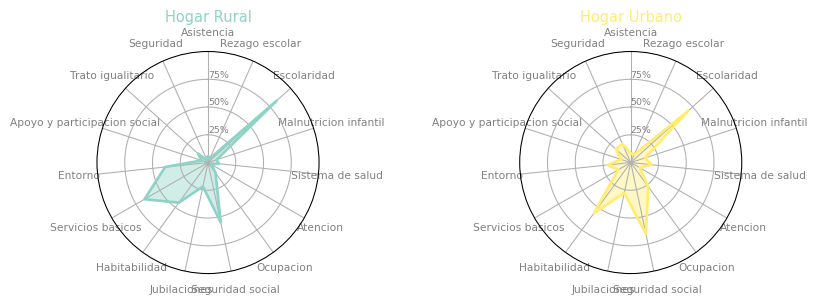

In [0]:
# EJECUCIÓN RADAR RURAL VS URBANO
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)




# Create a color palette:
my_palette = plt.cm.get_cmap("Set3", len(spider3.index))
 
# Loop to plot

for row in range(0, len(spider3.index)):

  if spider3["group"][row]=="Rural":
    aaa=len(spd3[spd3.zona == "Rural"])
  elif spider3["group"][row]=="Urbano":
    aaa=len(spd3[spd3.zona == "Urbano"])


  make_spider(spider3, row=row, title='Hogar '+spider3['group'][row], color=my_palette(row),max=aaa)
  

In [0]:
print(len(spd3[spd3.zona == "Urbano"]))
print(len(spd3[spd3.zona == "Rural"]))

7649
4743


In [0]:
# CALCULO FRECUENCIA DE CARENCIAS POR NUMPER
#MARCAPARAVOLVER
spd4=casen[["folio","numper","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
spd4=spd4.drop_duplicates()
spd4=spd4.drop("folio",axis=1)

#spd4["numper2"]=np.nan
spd4.loc[spd4["numper"] > 6, 'numper'] = 7 

grouped_spd4 = spd4.groupby(["numper"])
suma_spd4 = grouped_spd4.sum()
suma_spd4 = suma_spd4.reset_index()

suma_spd4['group']=np.nan
suma_spd4.loc[suma_spd4["numper"] == 1, 'group'] = "n=1" 
suma_spd4.loc[suma_spd4["numper"] == 2, 'group'] = "n=2" 
suma_spd4.loc[suma_spd4["numper"] == 3, 'group'] = "n=3" 
suma_spd4.loc[suma_spd4["numper"] == 4, 'group'] = "n=4" 
suma_spd4.loc[suma_spd4["numper"] == 5, 'group'] = "n=5" 
suma_spd4.loc[suma_spd4["numper"] == 6 , 'group'] = "n=6" 
suma_spd4.loc[suma_spd4["numper"] == 7 , 'group'] = "n>6" 

spider4=suma_spd4.drop("numper", axis=1)
spider4

ttttt = spider4.pop("group")
spider4.insert(0, "group", ttttt)
print(len(spd4[spd4.numper==1].index))
print(len(spd4[spd4.numper==2].index))
print(len(spd4[spd4.numper==3].index))
print(len(spd4[spd4.numper==4].index))
print(len(spd4[spd4.numper==5].index))
print(len(spd4[spd4.numper==6].index))
print(len(spd4[spd4.numper>6].index))

1246
2607
2681
2305
1780
911
862


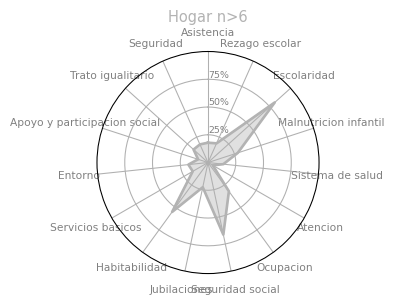

In [0]:
# EJECUCIÓN RADAR NUMPER
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)




# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(spider4.index))
 
# Loop to plot

for row in range(0, len(spider4.index)):

  if spider4["group"][row]=="n=1":
    aaa=len(spd4[spd4.numper ==1 ])
  elif spider4["group"][row]=="n=2":
    aaa=len(spd4[spd4.numper == 2])
  elif spider4["group"][row]=="n=3":
    aaa=len(spd4[spd4.numper == 3])
  elif spider4["group"][row]=="n=4":
    aaa=len(spd4[spd4.numper == 4])
  elif spider4["group"][row]=="n=5":
    aaa=len(spd4[spd4.numper == 5])
  elif spider4["group"][row]=="n=6":
    aaa=len(spd4[spd4.numper == 6])
  elif spider4["group"][row]=="n>6":
    aaa=len(spd4[spd4.numper>6])

  if spider4["group"][row]=="n>6":
    make_spider(spider4, row=row, title='Hogar '+spider4['group'][row], color=my_palette(row),max=aaa)

12392


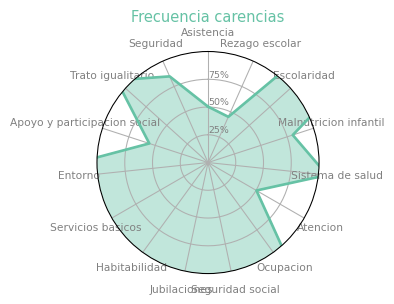

In [0]:

# CALCULO FRECUENCIA DE CARENCIAS GENERAL
#MARCAPARAVOLVER
spd5=casen[["folio","numper","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
spd5=spd5.drop_duplicates()
spd5=spd5.drop("folio",axis=1)




#spd4["numper2"]=np.nan
spd5.loc[spd5["numper"] > 0, 'numper'] = 1 

grouped_spd5 = spd5.groupby(["numper"])
suma_spd5 = grouped_spd5.sum()
suma_spd5 = suma_spd5.reset_index()

suma_spd5['group']=np.nan
suma_spd5.loc[suma_spd5["numper"] == 1, 'group'] = "carencias" 

spider5=suma_spd5.drop("numper", axis=1)
spider5

spider5=suma_spd5.drop("numper", axis=1)
tttttt = spider5.pop("group")
spider5.insert(0, "group", tttttt)

print(len(spd5.index))






# EJECUCIÓN RADAR GENERAL
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)




# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(spd5.index))
 
# Loop to plot

for row in range(0, len(spider5.index)):

  if spider4["group"][row]=="carencias":
    aaa=12392
  
  make_spider(spider5, row=row, title='Frecuencia '+spider5['group'][row], color=my_palette(row),max=aaa)

In [0]:
spider4

,group,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad
0,n=1,3.0,1.0,924.0,0.0,148.0,71.0,78.0,546.0,233.0,773.0,763.0,580.0,126.0,180.0,96.0
1,n=2,41.0,37.0,2084.0,19.0,364.0,208.0,331.0,1445.0,964.0,1205.0,1104.0,941.0,195.0,391.0,250.0
2,n=3,167.0,118.0,1974.0,225.0,490.0,191.0,575.0,1735.0,737.0,1370.0,847.0,682.0,187.0,426.0,290.0
3,n=4,221.0,180.0,1633.0,369.0,415.0,207.0,601.0,1526.0,505.0,1029.0,672.0,559.0,177.0,389.0,329.0
4,n=5,178.0,189.0,1288.0,347.0,239.0,119.0,480.0,1196.0,339.0,1104.0,413.0,366.0,137.0,274.0,260.0
5,n>5,283.0,274.0,1385.0,463.0,256.0,97.0,530.0,1189.0,409.0,943.0,326.0,326.0,164.0,305.0,281.0


In [0]:
# CALCULO FRECUENCIA DE CARENCIAS AGRUPADAS POR DIMENSION Y TIPO DE HOGAR
dim3=dim1.copy()
dim31=dim3[dim3.d==1]
dim32=dim3[dim3.d==2]
dim33=dim3[dim3.d==3]
dim34=dim3[dim3.d==4]
dim35=dim3[dim3.d==5]
dim36=dim3[dim3.d==6]
#############################

casen4=dim3.copy()
casen4=casen4.drop("folio",axis=1)


grouped_casen4 = casen4.groupby(["d"])
suma_casen4 = grouped_casen4.sum()
suma_casen4 = suma_casen4.reset_index()

suma_casen4['group']=np.nan
suma_casen4.loc[suma_casen4["d"] == 1, 'group'] = "unipersonal" 
suma_casen4.loc[suma_casen4["d"] == 2, 'group'] = "monoparental nuclear" 
suma_casen4.loc[suma_casen4["d"] == 3, 'group'] = "biparental nuclear" 
suma_casen4.loc[suma_casen4["d"] == 4, 'group'] = "monoparental extendido" 
suma_casen4.loc[suma_casen4["d"] == 5, 'group'] = "biparental extendido" 
suma_casen4.loc[suma_casen4["d"] == 6, 'group'] = "censal" 

spider2=suma_casen4.drop("d", axis=1)
spider2

tttt = spider2.pop("group")
spider2.insert(0, "group", tttt)
spider2

,group,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
0,unipersonal,928.0,219.0,857.0,2116.0,402.0
1,monoparental nuclear,1917.0,646.0,2307.0,2541.0,863.0
2,biparental nuclear,5037.0,1960.0,6316.0,6473.0,1920.0
3,monoparental extendido,1232.0,486.0,1403.0,1130.0,525.0
4,biparental extendido,1816.0,889.0,2450.0,1672.0,707.0
5,censal,50.0,28.0,86.0,71.0,40.0


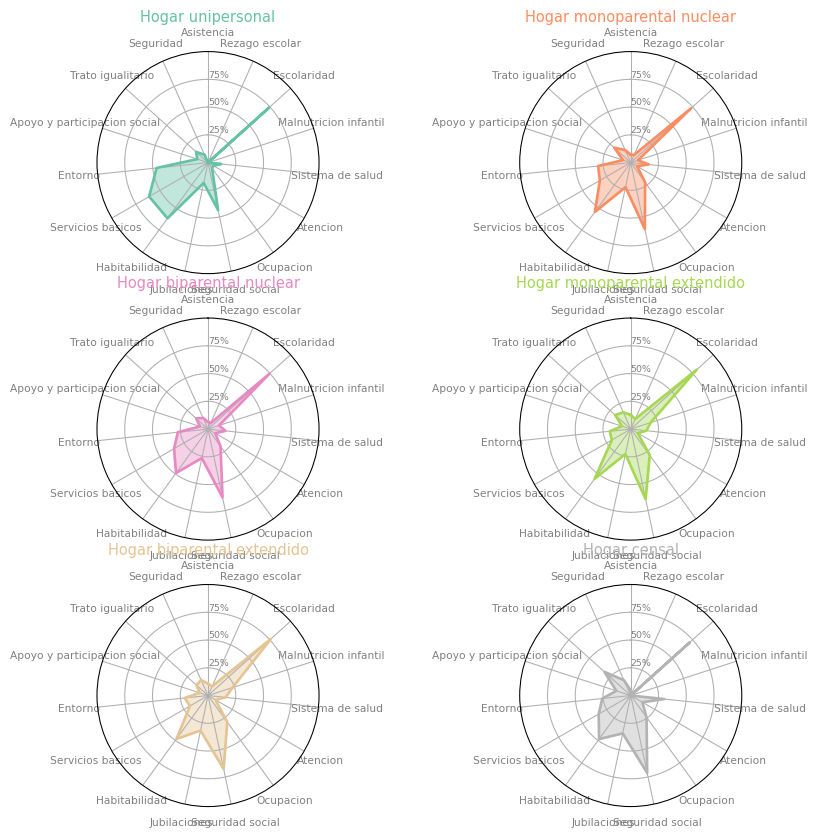

In [0]:
# EJECUCIÓN RADAR 1
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)




# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(spider1.index))
 
# Loop to plot

for row in range(0, len(spider1.index)):

  if spider1["group"][row]=="unipersonal":
    aaa=len(tipohogares.loc[tipohogares["d"] == 1].index)
  elif spider1["group"][row]=="monoparental nuclear":
    aaa=len(tipohogares.loc[tipohogares["d"] == 2].index)
  elif spider1["group"][row]=="biparental nuclear":
    aaa=len(tipohogares.loc[tipohogares["d"] == 3].index)
  elif spider1["group"][row]=="monoparental extendido":
    aaa=len(tipohogares.loc[tipohogares["d"] == 4].index)
  elif spider1["group"][row]=="biparental extendido":
    aaa=len(tipohogares.loc[tipohogares["d"] == 5].index)
  elif spider1["group"][row]=="censal":
    aaa=len(tipohogares.loc[tipohogares["d"] == 6].index)

  make_spider(spider1, row=row, title='Hogar '+spider1['group'][row], color=my_palette(row),max=aaa)
  

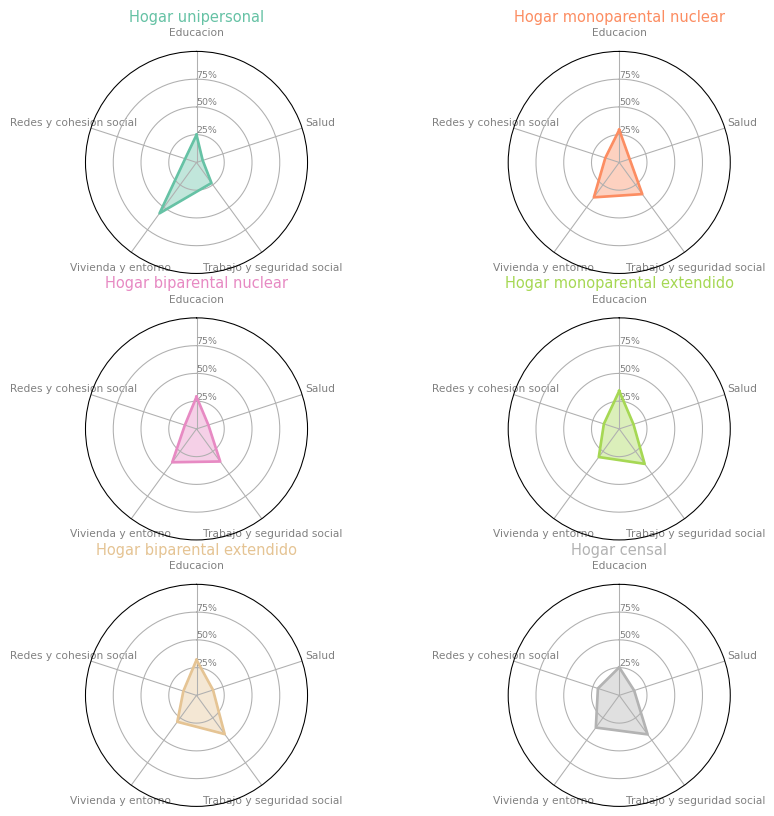

In [0]:
# EJECUCIÓN RADAR 2
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(spider2.index))
 
# Loop to plot

for row in range(0, len(spider2.index)):

  if spider2["group"][row]=="unipersonal":
    aaa=len(tipohogares.loc[tipohogares["d"] == 1].index)*3
  elif spider2["group"][row]=="monoparental nuclear":
    aaa=len(tipohogares.loc[tipohogares["d"] == 2].index)*3
  elif spider2["group"][row]=="biparental nuclear":
    aaa=len(tipohogares.loc[tipohogares["d"] == 3].index)*3
  elif spider2["group"][row]=="monoparental extendido":
    aaa=len(tipohogares.loc[tipohogares["d"] == 4].index)*3
  elif spider2["group"][row]=="biparental extendido":
    aaa=len(tipohogares.loc[tipohogares["d"] == 5].index)*3
  elif spider2["group"][row]=="censal":
    aaa=len(tipohogares.loc[tipohogares["d"] == 6].index)*3

  make_spider(spider2, row=row, title='Hogar '+spider2['group'][row], color=my_palette(row),max=aaa)

  plt.savefig("intento1.png",bbox_inches="tight")

# Gráfico IPM vs Y


In [0]:
# Depuracion casen para trabajar con ingresos por hogares

casen_general_hogares=casen_general[[f1,f2,f3,"pobreza","folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad","d"]]
casen_general_hogares=casen_general_hogares.drop_duplicates()
casen_general_hogares['IntPob']=np.nan
mult1=7.5
mult2=(10/3)

for p in casen_general_hogares.index:
  c11=casen_general_hogares['Asistencia'][p]
  c12=casen_general_hogares['Rezago escolar'][p]
  c13=casen_general_hogares['Escolaridad'][p]
  c21=casen_general_hogares['Malnutricion infantil'][p]
  c22=casen_general_hogares['Sistema de salud'][p]
  c23=casen_general_hogares['Atencion'][p]
  c31=casen_general_hogares['Ocupacion'][p]
  c32=casen_general_hogares['Seguridad social'][p]
  c33=casen_general_hogares['Jubilaciones'][p]
  c41=casen_general_hogares['Habitabilidad'][p]
  c42=casen_general_hogares['Servicios basicos'][p]
  c43=casen_general_hogares['Entorno'][p]
  c51=casen_general_hogares['Apoyo y participacion social'][p]
  c52=casen_general_hogares['Trato igualitario'][p]
  c53=casen_general_hogares['Seguridad'][p]
  k=1+5+c12
  c=round(mult1*(c11+c12+c13+c21+c22+c23+c31+c32+c33+c41+c42+c43)+mult2*(c51+c52+c53),2)

  casen_general_hogares['IntPob'][p]=c

print("total hogares casen 2017:",len(casen_general_hogares))
casen_general_hogares.dropna(subset=['IntPob'])
print("total hogares casen 2017 s/IPM:", len(casen_general_hogares))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


total hogares casen 2017: 71146
total hogares casen 2017 s/IPM: 71146


In [0]:
# ASIGNACION COEFICIENTE DE AJUSTE POR NUMPER PARA YPC 



prueba=casen_general_hogares.copy()

prueba["coef"]=np.nan

n1=158145
n2=128454
n3=113742
n4=104337
n5=97581
n6=92387
n7=88212
n8=84748
n9=81806
n10=79260

for p in prueba.index:
  p1=prueba["ypc"][p]

  if prueba["numper"][p]==1:
    prueba["coef"][p]=p1/n1

  elif prueba["numper"][p]==2:
    prueba["coef"][p]=p1/n2

  elif prueba["numper"][p]==3:
    prueba["coef"][p]=p1/n3

  elif prueba["numper"][p]==4:
    prueba["coef"][p]=p1/n4  

  elif prueba["numper"][p]==5:
    prueba["coef"][p]=p1/n5

  elif prueba["numper"][p]==6:
    prueba["coef"][p]=p1/n6

  elif prueba["numper"][p]==7:
    prueba["coef"][p]=p1/n7  

  elif prueba["numper"][p]==8:
    prueba["coef"][p]=p1/n8

  elif prueba["numper"][p]==9:
    prueba["coef"][p]=p1/n9

  elif prueba["numper"][p]==10:
    prueba["coef"][p]=p1/n4  


  else:
    prueba["coef"][p]=np.nan   

prueba=prueba.dropna(subset=['coef'])

prueba.to_excel(excel_writer = "YPC_vs_IPM.xlsx")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to b

No handles with labels found to put in legend.


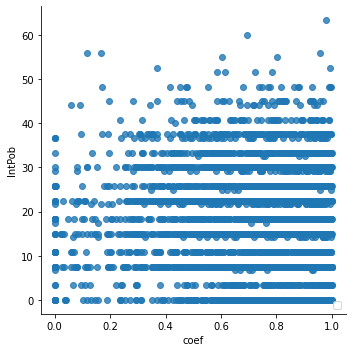

In [0]:
# grafico scatter


sb.lmplot( x="coef", y="IntPob", data=prueba[prueba.coef<=1], fit_reg=False, legend=False)
plt.legend(loc='lower right')
plt.show()



No handles with labels found to put in legend.


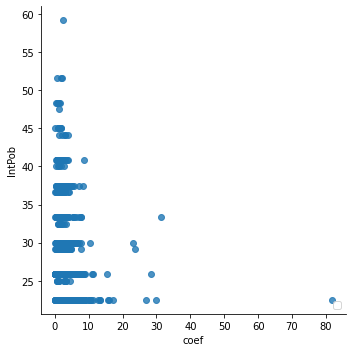

In [0]:
sb.lmplot( x="coef", y="IntPob", data=prueba[prueba.IntPob>=22.5], fit_reg=False, legend=False)
plt.legend(loc='lower right')
plt.show()


In [0]:
print(len(prueba[prueba.IntPob>=22.5]))
prueba[prueba.IntPob>=22.5]

3853


,zona,numper,ypc,pobreza,folio,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,d,IntPob,coef
1,Urbano,1.0,211091,No pobres,110110020301,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,30.00,1.334794
7,Urbano,2.0,231667,No pobres,110110020601,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2,51.67,1.803502
19,Urbano,1.0,200000,No pobres,110110030401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,36.67,1.264662
26,Urbano,1.0,447482,No pobres,110110040201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1,29.17,2.829568
49,Urbano,2.0,160000,No pobres,110110050801,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2,29.17,1.245582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216426,Rural,2.0,217500,No pobres,1520130021201,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3,37.50,1.693213
216428,Rural,2.0,396250,No pobres,1520130021301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3,22.50,3.084762
216433,Rural,1.0,154932,Pobres no extremos,1520130021501,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1,30.00,0.979683
216434,Rural,2.0,254646,No pobres,1520130021601,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,22.50,1.982391
